In [2]:
import torch
torch.__version__

'1.1.0'

In [7]:
PATH_to_log_dir = '/data/cv_final/CT-Predict/2D-Pretrain/result' 

In [56]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import numpy as np
from datetime import datetime
import pandas as pd
import random 
from torchvision.datasets import ImageFolder
import re
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import roc_auc_score
from skimage.io import imread, imsave
import skimage
from PIL import ImageFile
from PIL import Image

torch.cuda.empty_cache()

In [57]:
# normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

########## Mean and std are calculated from the train dataset
normalize = transforms.Normalize(mean=[0.45271412, 0.45271412, 0.45271412],
                                     std=[0.33165374, 0.33165374, 0.33165374])
train_transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
    transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(90),
    # random brightness and random contrast
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    normalize
])

val_transformer = transforms.Compose([
#     transforms.Resize(224),
#     transforms.CenterCrop(224),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

In [81]:
batchsize=8
def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data

class CovidCTDataset(Dataset):
    def __init__(self, root_dir, txt_COVID, txt_NonCOVID, transform=None):
        """
        Args:
            txt_path (string): Path to the txt file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        File structure:
        - root_dir
            - CT_COVID
                - img1.png
                - img2.png
                - ......
            - CT_NonCOVID
                - img1.png
                - img2.png
                - ......
        - root_dir /data/Data/
            - COVID19
                - img1.png
                - img2.png
                - ......
            - Normal
                - img1.png
                - img2.png
                - ......
        txt_path:
        - COVID19
            - test_COVID.txt
            - train_COVID.txt
            - val_COVID.txt
        - Normal
            - ...
        """
        self.root_dir = root_dir
        self.txt_path = [txt_COVID,txt_NonCOVID]
        # 2019
#         self.classes = ['COVID19', 'Normal']
        # UCSD
        self.classes = ['CT_COVID', 'CT_NonCOVID']
        self.num_cls = len(self.classes)
        self.img_list = []
        for c in range(self.num_cls):
            cls_list = [[os.path.join(self.root_dir,self.classes[c],item), c] for item in read_txt(self.txt_path[c])]
#             print(cls_list)
            self.img_list += cls_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.img_list[idx][0]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        sample = {'img': image,
                  'label': int(self.img_list[idx][1])}
        return sample


if __name__ == '__main__':
    trainset = CovidCTDataset(root_dir='/data/COVID-CT/Data',
                              txt_COVID='/data/COVID-CT/Data-split/COVID/trainCT_COVID.txt',
                              txt_NonCOVID='/data/COVID-CT/Data-split/NonCOVID/trainCT_NonCOVID.txt',
                              transform= train_transformer)
    valset = CovidCTDataset(root_dir='/data/COVID-CT/Data',
                              txt_COVID='/data/COVID-CT/Data-split/COVID/valCT_COVID.txt',
                              txt_NonCOVID='/data/COVID-CT/Data-split/NonCOVID/valCT_NonCOVID.txt',
                              transform= val_transformer)
    testset = CovidCTDataset(root_dir='/data/COVID-CT/Data',
                              txt_COVID='/data/COVID-CT/Data-split/COVID/testCT_COVID.txt',
                              txt_NonCOVID='/data/COVID-CT/Data-split/NonCOVID/testCT_NonCOVID.txt',
                              transform= val_transformer)
    print(trainset.__len__())
    print(valset.__len__())
    print(testset.__len__())

    train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
    val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
    test_loader = DataLoader(testset, batch_size=batchsize, drop_last=False, shuffle=False)
    

425
118
203


torch.Size([8, 3, 224, 224])


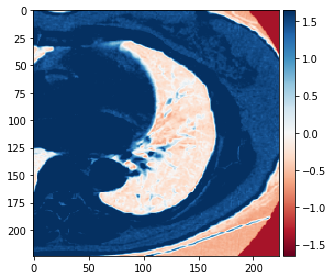

In [82]:
for batch_index, batch_samples in enumerate(train_loader):      
        data, target = batch_samples['img'], batch_samples['label']
        break
# io.imread 读出图片格式是 uint8(unsigned int) ；value是 numpy array ；
# 图像数据是以 RGB 的格式进行存储的，通道值默认范围0-255
skimage.io.imshow(data[0,1,:,:].numpy())
print(data.shape)

In [85]:
# mixup
'''Use mixup to do data augmentation'''

def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
#         print('lam',lam)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
#     print(pred)
#     print(y_a)
#     print('criterion',criterion(pred, y_a))
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [88]:
#training process is defined here 

alpha = None
## alpha is None if mixup is not used
alpha_name = f'{alpha}'
device = 'cuda'

def train(optimizer, epoch):
    
    model.train()
    
    train_loss = 0
    train_correct = 0
    
    for batch_index, batch_samples in enumerate(train_loader):
        
        # move data to device
        data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
        
        ## adjust data to meet the input dimension of model
#         data = data[:, 0, :, :]
#         data = data[:, None, :, :]    
        
        #mixup
        data, targets_a, targets_b, lam = mixup_data(data, target, alpha, use_cuda=True)
        
        
        optimizer.zero_grad()
        output = model(data)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(output, target.long())
        
        #mixup loss
        loss = mixup_criterion(criteria, output, targets_a, targets_b, lam)

        train_loss += criteria(output, target.long())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.long().view_as(pred)).sum().item()
    
        # Display progress and write to tensorboard
        if batch_index % bs == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}'.format(
                epoch, batch_index, len(train_loader),
                100.0 * batch_index / len(train_loader), loss.item()/ bs))
    his['train_loss'].append(train_loss.data.cpu().numpy()/len(train_loader.dataset))
    his['train_acc'].append(train_correct / len(train_loader.dataset))
    
#     print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         train_loss/len(train_loader.dataset), train_correct, len(train_loader.dataset),
#         100.0 * train_correct / len(train_loader.dataset)))
    p = os.path.join(PATH_to_log_dir,'/{}.txt'.format(modelname))
    f = open(p, 'a+')
    f.write('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        train_loss/len(train_loader.dataset), train_correct, len(train_loader.dataset),
        100.0 * train_correct / len(train_loader.dataset)))
    f.write('\n')
    f.close()

In [89]:
# #val process is defined here

def val(epoch):
    
    model.eval()
    val_loss = 0
    correct = 0
    results = []
    
    TP = 0
    TN = 0
    FN = 0
    FP = 0
    
    
    criteria = nn.CrossEntropyLoss()
    # Don't update model
    with torch.no_grad():
        tpr_list = []
        fpr_list = []
        
        predlist=[]
        scorelist=[]
        targetlist=[]
        # Predict
        for batch_index, batch_samples in enumerate(val_loader):
            data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
            
#             data = data[:, 0, :, :]
#             data = data[:, None, :, :]
            output = model(data)
            
            val_loss += criteria(output, target.long())
            score = F.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)
#             print('target',target.long()[:, 2].view_as(pred))
            correct += pred.eq(target.long().view_as(pred)).sum().item()
            
#             print(output[:,1].cpu().numpy())
#             print((output[:,1]+output[:,0]).cpu().numpy())
#             predcpu=(output[:,1].cpu().numpy())/((output[:,1]+output[:,0]).cpu().numpy())
            targetcpu=target.long().cpu().numpy()
            predlist=np.append(predlist, pred.cpu().numpy())
            scorelist=np.append(scorelist, score.cpu().numpy()[:,1])
            targetlist=np.append(targetlist,targetcpu)
        his['val_loss'].append(val_loss.data.cpu().numpy()/len(val_loader.dataset))
        his['val_acc'].append(correct/len(val_loader.dataset))       
    return targetlist, scorelist, predlist


In [90]:
# test process is defined here 

def test(epoch):
    
    model.eval()
    test_loss = 0
    correct = 0
    results = []
    
    TP = 0
    TN = 0
    FN = 0
    FP = 0
    
    
    criteria = nn.CrossEntropyLoss()
    # Don't update model
    with torch.no_grad():
        tpr_list = []
        fpr_list = []
        
        predlist=[]
        scorelist=[]
        targetlist=[]
        # Predict
        for batch_index, batch_samples in enumerate(test_loader):
            data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
#             data = data[:, 0, :, :]
#             data = data[:, None, :, :]
#             print(target)
            output = model(data)
            
            test_loss += criteria(output, target.long())
            score = F.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)
#             print('target',target.long()[:, 2].view_as(pred))
            correct += pred.eq(target.long().view_as(pred)).sum().item()
#             TP += ((pred == 1) & (target.long()[:, 2].view_as(pred).data == 1)).cpu().sum()
#             TN += ((pred == 0) & (target.long()[:, 2].view_as(pred) == 0)).cpu().sum()
# #             # FN    predict 0 label 1
#             FN += ((pred == 0) & (target.long()[:, 2].view_as(pred) == 1)).cpu().sum()
# #             # FP    predict 1 label 0
#             FP += ((pred == 1) & (target.long()[:, 2].view_as(pred) == 0)).cpu().sum()
#             print(TP,TN,FN,FP)
            
            
#             print(output[:,1].cpu().numpy())
#             print((output[:,1]+output[:,0]).cpu().numpy())
#             predcpu=(output[:,1].cpu().numpy())/((output[:,1]+output[:,0]).cpu().numpy())
            targetcpu=target.long().cpu().numpy()
            predlist=np.append(predlist, pred.cpu().numpy())
            scorelist=np.append(scorelist, score.cpu().numpy()[:,1])
            targetlist=np.append(targetlist,targetcpu)
        his['test_loss'].append(test_loss.data.cpu().numpy()/len(test_loader.dataset))
        his['test_acc'].append(correct/len(test_loader.dataset))
    return targetlist, scorelist, predlist
    

In [93]:
"""Load Self-Trans model"""
"""Change names and locations to the Self-Trans.pt"""

import torchvision.models as models

model = models.densenet169(pretrained=True).cuda()
# pretrained_net = torch.load('model_backup/Dense169.pt')
# pretrained_net = torch.load('model_backup/mixup/Dense169_0.6.pt')
path = '/data/COVID-CT/baseline-methods/Self-Trans/Self-Trans.pt'
pretrained_net = torch.load(path)
''
model.load_state_dict(pretrained_net)

modelname = 'Dense169'

In [99]:
his = {}
his['train_loss'] = []
his['train_acc'] = []
his['val_loss'] = []
his['val_acc'] = []
his['test_loss'] = []
his['test_acc'] = []

In [ ]:
import datetime
# train
bs =batchsize
votenum = 10
import warnings
warnings.filterwarnings('ignore')

r_list = []
p_list = []
acc_list = []
AUC_list = []
# TP = 0
# TN = 0
# FN = 0
# FP = 0
vote_pred = np.zeros(valset.__len__())
vote_score = np.zeros(valset.__len__())

lr = 0.001
#optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)
optimizer = optim.Adam(model.parameters(), lr=lr) 
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)
                                             
scheduler = StepLR(optimizer, step_size=1)

total_epoch = 500
for epoch in range(1, total_epoch+1):
    train(optimizer, epoch)
    
    targetlist, scorelist, predlist = val(epoch)
    print('target',targetlist)
    print('score',scorelist)
    print('predict',predlist)
    vote_pred = vote_pred + predlist 
    vote_score = vote_score + scorelist 

    if epoch % votenum == 0:
        
        # major vote
        vote_pred[vote_pred <= (votenum/2)] = 0
        vote_pred[vote_pred > (votenum/2)] = 1
        vote_score = vote_score/votenum
        
        print('vote_pred', vote_pred)
        print('targetlist', targetlist)
        TP = ((vote_pred == 1) & (targetlist == 1)).sum()
        TN = ((vote_pred == 0) & (targetlist == 0)).sum()
        FN = ((vote_pred == 0) & (targetlist == 1)).sum()
        FP = ((vote_pred == 1) & (targetlist == 0)).sum()
        
        
        print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
        print('TP+FP',TP+FP)
        p = TP / (TP + FP)
        print('precision',p)
        p = TP / (TP + FP)
        r = TP / (TP + FN)
        print('recall',r)
        F1 = 2 * r * p / (r + p)
        acc = (TP + TN) / (TP + TN + FP + FN)
        print('F1',F1)
        print('acc',acc)
        AUC = roc_auc_score(targetlist, vote_score)
        print('AUCp', roc_auc_score(targetlist, vote_pred))
        print('AUC', AUC)
        
        
        
#         if epoch == total_epoch:
        torch.save(model.state_dict(), "/data/cv_final/CT-Predict/2D-Pretrain/result/UCSD_{}_{}_{}_{}.pt".format(modelname,alpha_name,epoch, datetime.datetime.now()))  

        vote_pred = np.zeros(valset.__len__())
        vote_score = np.zeros(valset.__len__())
        print('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},\
average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
        epoch, r, p, F1, acc, AUC))

        f = open('/data/cv_final/CT-Predict/2D-Pretrain/result/UCSD_{}_{}_{}_{}.txt'.format(modelname,alpha_name, epoch, lr), 'a+')
        f.write('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},\
average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
        epoch, r, p, F1, acc, AUC))\
        
        f.close()

Train Epoch: 1 [0/54 (0%)]	Train Loss: 0.049353
Train Epoch: 1 [8/54 (15%)]	Train Loss: 0.145719
Train Epoch: 1 [16/54 (30%)]	Train Loss: 0.071957
Train Epoch: 1 [24/54 (44%)]	Train Loss: 0.080796
Train Epoch: 1 [32/54 (59%)]	Train Loss: 0.076724
Train Epoch: 1 [40/54 (74%)]	Train Loss: 0.085022
Train Epoch: 1 [48/54 (89%)]	Train Loss: 0.082584
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.43733263 0.64158821 0.63629913 0.45369029 0.42826748 0.3934916
 0.63001209 0.52663428 0.3725259  0.19464758 0.39847839 0.26768851
 0.48327205 0.62162614 0.6333136  0.40076524 0.40509358 0.32877415
 0.47627252 0.5059039  0.41657823 0.42792645 0.43146864 0.39251885
 0.47928274 0

Train Epoch: 5 [0/54 (0%)]	Train Loss: 0.075991
Train Epoch: 5 [8/54 (15%)]	Train Loss: 0.102014
Train Epoch: 5 [16/54 (30%)]	Train Loss: 0.079451
Train Epoch: 5 [24/54 (44%)]	Train Loss: 0.090189
Train Epoch: 5 [32/54 (59%)]	Train Loss: 0.086520
Train Epoch: 5 [40/54 (74%)]	Train Loss: 0.071654
Train Epoch: 5 [48/54 (89%)]	Train Loss: 0.086903
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.57051235 0.7086814  0.60336179 0.55023348 0.57946396 0.55531055
 0.78146368 0.64198309 0.64387113 0.31556091 0.44555274 0.29251254
 0.43818718 0.6096496  0.53676945 0.55984432 0.66269386 0.32054138
 0.28280619 0.38689956 0.36115992 0.32158151 0.28943762 0.37446263
 0.44609383 

Train Epoch: 9 [0/54 (0%)]	Train Loss: 0.097066
Train Epoch: 9 [8/54 (15%)]	Train Loss: 0.132891
Train Epoch: 9 [16/54 (30%)]	Train Loss: 0.105365
Train Epoch: 9 [24/54 (44%)]	Train Loss: 0.093083
Train Epoch: 9 [32/54 (59%)]	Train Loss: 0.064649
Train Epoch: 9 [40/54 (74%)]	Train Loss: 0.059778
Train Epoch: 9 [48/54 (89%)]	Train Loss: 0.092783
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.41656986 0.76837569 0.71928972 0.32962829 0.26518816 0.34732038
 0.75292325 0.39004305 0.20478594 0.20181769 0.27322754 0.19965509
 0.29112357 0.39030984 0.4724308  0.26143602 0.1699862  0.35500529
 0.36389196 0.43092367 0.40654036 0.45596951 0.44348681 0.32480389
 0.28785622 

Train Epoch: 12 [0/54 (0%)]	Train Loss: 0.095720
Train Epoch: 12 [8/54 (15%)]	Train Loss: 0.098156
Train Epoch: 12 [16/54 (30%)]	Train Loss: 0.078651
Train Epoch: 12 [24/54 (44%)]	Train Loss: 0.058099
Train Epoch: 12 [32/54 (59%)]	Train Loss: 0.134939
Train Epoch: 12 [40/54 (74%)]	Train Loss: 0.084422
Train Epoch: 12 [48/54 (89%)]	Train Loss: 0.039080
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.07702759 0.73825634 0.80221009 0.11493168 0.05275566 0.02541466
 0.68542236 0.11621158 0.03878002 0.01824777 0.04333897 0.00336854
 0.08489477 0.82391143 0.75921434 0.10898937 0.2515502  0.26680374
 0.20994957 0.27442932 0.11553144 0.26739648 0.29348257 0.22292408
 0.40

Train Epoch: 16 [0/54 (0%)]	Train Loss: 0.079351
Train Epoch: 16 [8/54 (15%)]	Train Loss: 0.053784
Train Epoch: 16 [16/54 (30%)]	Train Loss: 0.076917
Train Epoch: 16 [24/54 (44%)]	Train Loss: 0.096367
Train Epoch: 16 [32/54 (59%)]	Train Loss: 0.131992
Train Epoch: 16 [40/54 (74%)]	Train Loss: 0.054661
Train Epoch: 16 [48/54 (89%)]	Train Loss: 0.111852
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.76865667 0.99100655 0.98744524 0.76794237 0.70927143 0.79269695
 0.96744943 0.87290758 0.69100648 0.19584674 0.54708391 0.16560324
 0.35978991 0.65875393 0.76873016 0.42639175 0.5727219  0.2961607
 0.31893116 0.47892478 0.59092301 0.3337377  0.54833102 0.64571095
 0.370

Train Epoch: 20 [0/54 (0%)]	Train Loss: 0.089357
Train Epoch: 20 [8/54 (15%)]	Train Loss: 0.080170
Train Epoch: 20 [16/54 (30%)]	Train Loss: 0.084322
Train Epoch: 20 [24/54 (44%)]	Train Loss: 0.099782
Train Epoch: 20 [32/54 (59%)]	Train Loss: 0.072266
Train Epoch: 20 [40/54 (74%)]	Train Loss: 0.061651
Train Epoch: 20 [48/54 (89%)]	Train Loss: 0.091822
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.33510479 0.76706141 0.7467407  0.18552892 0.18210623 0.45013776
 0.77851754 0.22373214 0.27428058 0.08849983 0.10268483 0.06862346
 0.1214909  0.80948603 0.82823282 0.1962661  0.20281187 0.09589476
 0.22798985 0.56423783 0.60055941 0.2109717  0.34094864 0.64386827
 0.39

Train Epoch: 23 [0/54 (0%)]	Train Loss: 0.098409
Train Epoch: 23 [8/54 (15%)]	Train Loss: 0.100795
Train Epoch: 23 [16/54 (30%)]	Train Loss: 0.068916
Train Epoch: 23 [24/54 (44%)]	Train Loss: 0.080562
Train Epoch: 23 [32/54 (59%)]	Train Loss: 0.117051
Train Epoch: 23 [40/54 (74%)]	Train Loss: 0.084272
Train Epoch: 23 [48/54 (89%)]	Train Loss: 0.073021
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.99992919 0.99999964 0.99999857 0.99842107 0.99312454 0.9985916
 0.99999988 0.99971431 0.9729346  0.47860104 0.55301458 0.12144654
 0.5954147  0.96885306 0.9951846  0.88570905 0.88376212 0.89986914
 0.62176692 0.73761457 0.84730339 0.95523304 0.98610759 0.9669503
 0.8897

Train Epoch: 27 [0/54 (0%)]	Train Loss: 0.073801
Train Epoch: 27 [8/54 (15%)]	Train Loss: 0.040805
Train Epoch: 27 [16/54 (30%)]	Train Loss: 0.028807
Train Epoch: 27 [24/54 (44%)]	Train Loss: 0.036820
Train Epoch: 27 [32/54 (59%)]	Train Loss: 0.044970
Train Epoch: 27 [40/54 (74%)]	Train Loss: 0.091508
Train Epoch: 27 [48/54 (89%)]	Train Loss: 0.069907
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.60990787 0.87285084 0.83522916 0.35072964 0.33919087 0.32158858
 0.84104264 0.35333261 0.19619009 0.10862952 0.18353762 0.09996722
 0.20233402 0.52701473 0.66457611 0.21987326 0.21574143 0.11155052
 0.20004973 0.33407378 0.34663829 0.17659627 0.38200787 0.51001173
 0.27


 The epoch is 30, average recall: 0.5862, average precision: 0.6415,average F1: 0.6126, average accuracy: 0.6356, average AUC: 0.6836
Train Epoch: 31 [0/54 (0%)]	Train Loss: 0.061140
Train Epoch: 31 [8/54 (15%)]	Train Loss: 0.070408
Train Epoch: 31 [16/54 (30%)]	Train Loss: 0.061852
Train Epoch: 31 [24/54 (44%)]	Train Loss: 0.081944
Train Epoch: 31 [32/54 (59%)]	Train Loss: 0.098950
Train Epoch: 31 [40/54 (74%)]	Train Loss: 0.033203
Train Epoch: 31 [48/54 (89%)]	Train Loss: 0.068100
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.99424052 0.99991214 0.99411064 0.82036322 0.98951602 0.99986291
 0.99846494 0.9974044  0.75274295 0.56164247 0.92290717 0.18072815
 0.7

target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.17293049 0.96527725 0.92455107 0.41965953 0.33141798 0.30317652
 0.89160061 0.3812803  0.25732163 0.19934878 0.33581069 0.21878143
 0.25729764 0.55003917 0.68551201 0.18609783 0.33566532 0.27847561
 0.26508531 0.3196165  0.5499143  0.25802484 0.3909097  0.61922437
 0.36576253 0.65741199 0.90484607 0.88034344 0.3844057  0.44679785
 0.87873578 0.60347146 0.46572977 0.44428548 0.28518373 0.19161206
 0.26929873 0.23888807 0.55038697 0.52361566 0.45449167 0.42225003
 0.22533292 0.33010212 0.42406094 0.67418182 0.94803703 0.77710074
 0.98768067 0.87795764 0.98483789 0.04830464 0.40861589 0.14667384
 0.68223739 0.24948177 0

Train Epoch: 38 [0/54 (0%)]	Train Loss: 0.099375
Train Epoch: 38 [8/54 (15%)]	Train Loss: 0.033688
Train Epoch: 38 [16/54 (30%)]	Train Loss: 0.040497
Train Epoch: 38 [24/54 (44%)]	Train Loss: 0.060568
Train Epoch: 38 [32/54 (59%)]	Train Loss: 0.039825
Train Epoch: 38 [40/54 (74%)]	Train Loss: 0.071336
Train Epoch: 38 [48/54 (89%)]	Train Loss: 0.042884
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.99581331 0.99966514 0.99931443 0.99705458 0.85485625 0.9455561
 0.99873847 0.99660528 0.99033523 0.57671273 0.3047761  0.0940324
 0.20875339 0.7555486  0.90579468 0.51295608 0.97380459 0.72416222
 0.14230692 0.32286665 0.42333266 0.46274441 0.68837804 0.94286597
 0.7617

Train Epoch: 41 [0/54 (0%)]	Train Loss: 0.082817
Train Epoch: 41 [8/54 (15%)]	Train Loss: 0.066309
Train Epoch: 41 [16/54 (30%)]	Train Loss: 0.076628
Train Epoch: 41 [24/54 (44%)]	Train Loss: 0.097785
Train Epoch: 41 [32/54 (59%)]	Train Loss: 0.030493
Train Epoch: 41 [40/54 (74%)]	Train Loss: 0.128383
Train Epoch: 41 [48/54 (89%)]	Train Loss: 0.084565
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.29902673 0.67566919 0.44056645 0.1055344  0.10911547 0.29312748
 0.36768556 0.36249468 0.3579002  0.04561435 0.02768609 0.05068735
 0.00458371 0.10734139 0.27131143 0.05280439 0.04604719 0.12619138
 0.03409611 0.16183388 0.38047412 0.10186955 0.24543558 0.55951983
 0.07

Train Epoch: 45 [0/54 (0%)]	Train Loss: 0.049623
Train Epoch: 45 [8/54 (15%)]	Train Loss: 0.037309
Train Epoch: 45 [16/54 (30%)]	Train Loss: 0.064791
Train Epoch: 45 [24/54 (44%)]	Train Loss: 0.024649
Train Epoch: 45 [32/54 (59%)]	Train Loss: 0.036416
Train Epoch: 45 [40/54 (74%)]	Train Loss: 0.077064
Train Epoch: 45 [48/54 (89%)]	Train Loss: 0.046365
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.06581102 0.68272662 0.15903978 0.10128611 0.90341526 0.4346357
 0.19160241 0.69923979 0.34302431 0.34341666 0.97582823 0.21374476
 0.6925928  0.28798047 0.48137474 0.52076268 0.77871144 0.3675749
 0.76501381 0.32857037 0.75896555 0.61889672 0.96961445 0.70367086
 0.6646

Train Epoch: 49 [0/54 (0%)]	Train Loss: 0.062715
Train Epoch: 49 [8/54 (15%)]	Train Loss: 0.069647
Train Epoch: 49 [16/54 (30%)]	Train Loss: 0.066728
Train Epoch: 49 [24/54 (44%)]	Train Loss: 0.105156
Train Epoch: 49 [32/54 (59%)]	Train Loss: 0.039851
Train Epoch: 49 [40/54 (74%)]	Train Loss: 0.066472
Train Epoch: 49 [48/54 (89%)]	Train Loss: 0.029248
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.03910713 0.7641663  0.59500217 0.11478358 0.06970075 0.12804298
 0.6046769  0.07876398 0.13425295 0.01041183 0.01534308 0.00400054
 0.0088925  0.14182463 0.09977801 0.01956601 0.0360562  0.08534147
 0.07807673 0.08963352 0.27604571 0.09865106 0.56417161 0.83359075
 0.07

Train Epoch: 52 [0/54 (0%)]	Train Loss: 0.141998
Train Epoch: 52 [8/54 (15%)]	Train Loss: 0.108043
Train Epoch: 52 [16/54 (30%)]	Train Loss: 0.039704
Train Epoch: 52 [24/54 (44%)]	Train Loss: 0.031428
Train Epoch: 52 [32/54 (59%)]	Train Loss: 0.019145
Train Epoch: 52 [40/54 (74%)]	Train Loss: 0.027074
Train Epoch: 52 [48/54 (89%)]	Train Loss: 0.090479
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.99881065 0.99999976 0.99996996 0.99932873 0.5296191  0.73542684
 0.99999821 0.9973532  0.50629371 0.7557863  0.05633108 0.01208279
 0.06772368 0.94888818 0.91062903 0.85176486 0.04364113 0.20707501
 0.04244329 0.0637493  0.14183685 0.18232735 0.79266179 0.44753486
 0.08

Train Epoch: 56 [0/54 (0%)]	Train Loss: 0.019751
Train Epoch: 56 [8/54 (15%)]	Train Loss: 0.038474
Train Epoch: 56 [16/54 (30%)]	Train Loss: 0.054690
Train Epoch: 56 [24/54 (44%)]	Train Loss: 0.082137
Train Epoch: 56 [32/54 (59%)]	Train Loss: 0.034882
Train Epoch: 56 [40/54 (74%)]	Train Loss: 0.109360
Train Epoch: 56 [48/54 (89%)]	Train Loss: 0.054173
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [9.51797783e-01 9.99969959e-01 9.97144043e-01 9.80194092e-01
 6.95567012e-01 8.86392370e-02 9.99415278e-01 5.31289220e-01
 5.00562966e-01 1.25934118e-02 7.49022067e-01 4.68818191e-03
 2.61750758e-01 4.18546021e-01 7.52433002e-01 1.66961432e-01
 1.01289988e-01 2.88585991e-0

Train Epoch: 59 [0/54 (0%)]	Train Loss: 0.064732
Train Epoch: 59 [8/54 (15%)]	Train Loss: 0.090197
Train Epoch: 59 [16/54 (30%)]	Train Loss: 0.067641
Train Epoch: 59 [24/54 (44%)]	Train Loss: 0.032063
Train Epoch: 59 [32/54 (59%)]	Train Loss: 0.040261
Train Epoch: 59 [40/54 (74%)]	Train Loss: 0.013734
Train Epoch: 59 [48/54 (89%)]	Train Loss: 0.051740
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [1.67759076e-01 8.24653089e-01 8.37028772e-03 1.51616544e-01
 2.26514135e-02 2.55576777e-03 4.91159588e-01 1.79509297e-01
 1.26957949e-02 4.54604672e-03 2.03532819e-02 5.02902223e-03
 1.73871100e-04 2.32823994e-02 5.46338372e-02 3.09312204e-03
 1.94381908e-04 1.98675692e-0

Train Epoch: 62 [0/54 (0%)]	Train Loss: 0.047915
Train Epoch: 62 [8/54 (15%)]	Train Loss: 0.065433
Train Epoch: 62 [16/54 (30%)]	Train Loss: 0.026098
Train Epoch: 62 [24/54 (44%)]	Train Loss: 0.048551
Train Epoch: 62 [32/54 (59%)]	Train Loss: 0.026789
Train Epoch: 62 [40/54 (74%)]	Train Loss: 0.056132
Train Epoch: 62 [48/54 (89%)]	Train Loss: 0.092790
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.78320283 0.99889851 0.99855632 0.97831136 0.92887306 0.6126554
 0.99709094 0.96763527 0.33416256 0.14130244 0.98782301 0.13681045
 0.90522796 0.89215207 0.77429843 0.27180731 0.9258703  0.47753993
 0.90015543 0.81322944 0.92373955 0.91822481 0.98899031 0.98758262
 0.898

Train Epoch: 66 [0/54 (0%)]	Train Loss: 0.063237
Train Epoch: 66 [8/54 (15%)]	Train Loss: 0.017496
Train Epoch: 66 [16/54 (30%)]	Train Loss: 0.046128
Train Epoch: 66 [24/54 (44%)]	Train Loss: 0.067801
Train Epoch: 66 [32/54 (59%)]	Train Loss: 0.074529
Train Epoch: 66 [40/54 (74%)]	Train Loss: 0.041374
Train Epoch: 66 [48/54 (89%)]	Train Loss: 0.032560
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.02190429 0.96373922 0.96048623 0.05943716 0.03886744 0.04407642
 0.93540746 0.04380803 0.08843964 0.07154575 0.05672888 0.01983184
 0.01559854 0.51727235 0.1391179  0.01245462 0.02619602 0.09187363
 0.07007131 0.42160252 0.66492176 0.38001531 0.87916875 0.99571925
 0.20

Train Epoch: 70 [0/54 (0%)]	Train Loss: 0.060950
Train Epoch: 70 [8/54 (15%)]	Train Loss: 0.052625
Train Epoch: 70 [16/54 (30%)]	Train Loss: 0.039331
Train Epoch: 70 [24/54 (44%)]	Train Loss: 0.051895
Train Epoch: 70 [32/54 (59%)]	Train Loss: 0.028148
Train Epoch: 70 [40/54 (74%)]	Train Loss: 0.149688
Train Epoch: 70 [48/54 (89%)]	Train Loss: 0.013174
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [3.87298346e-01 7.97104955e-01 6.19427741e-01 3.70267123e-01
 2.67627090e-01 1.76748291e-01 5.64484060e-01 3.18698466e-01
 7.52302930e-02 4.49550688e-01 6.09124720e-01 1.87374562e-01
 3.90395194e-01 1.02414250e-01 2.06365615e-01 5.38271405e-02
 2.76429635e-02 1.11449718e-0

Train Epoch: 73 [0/54 (0%)]	Train Loss: 0.040165
Train Epoch: 73 [8/54 (15%)]	Train Loss: 0.023171
Train Epoch: 73 [16/54 (30%)]	Train Loss: 0.031899
Train Epoch: 73 [24/54 (44%)]	Train Loss: 0.030984
Train Epoch: 73 [32/54 (59%)]	Train Loss: 0.033823
Train Epoch: 73 [40/54 (74%)]	Train Loss: 0.054502
Train Epoch: 73 [48/54 (89%)]	Train Loss: 0.031218
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.23956552 0.99534011 0.97079998 0.67754984 0.53868639 0.28560153
 0.99168229 0.65691173 0.10792361 0.27095619 0.75963527 0.04340538
 0.11140665 0.81584197 0.80550897 0.32456928 0.25569797 0.28886929
 0.49525985 0.5315153  0.82843918 0.80794519 0.98732346 0.96112198
 0.79

Train Epoch: 77 [0/54 (0%)]	Train Loss: 0.010472
Train Epoch: 77 [8/54 (15%)]	Train Loss: 0.102267
Train Epoch: 77 [16/54 (30%)]	Train Loss: 0.059867
Train Epoch: 77 [24/54 (44%)]	Train Loss: 0.021955
Train Epoch: 77 [32/54 (59%)]	Train Loss: 0.020235
Train Epoch: 77 [40/54 (74%)]	Train Loss: 0.018707
Train Epoch: 77 [48/54 (89%)]	Train Loss: 0.036937
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.13301656 0.95409232 0.97488201 0.98656255 0.70710665 0.15230322
 0.95237237 0.73869932 0.4064312  0.5533179  0.86466819 0.18366781
 0.6110692  0.76436085 0.78858942 0.4342066  0.66094649 0.10577991
 0.07331954 0.16595085 0.30729139 0.94887435 0.98989785 0.98668844
 0.38

Train Epoch: 80 [0/54 (0%)]	Train Loss: 0.083147
Train Epoch: 80 [8/54 (15%)]	Train Loss: 0.051844
Train Epoch: 80 [16/54 (30%)]	Train Loss: 0.118181
Train Epoch: 80 [24/54 (44%)]	Train Loss: 0.059353
Train Epoch: 80 [32/54 (59%)]	Train Loss: 0.021256
Train Epoch: 80 [40/54 (74%)]	Train Loss: 0.023696
Train Epoch: 80 [48/54 (89%)]	Train Loss: 0.048400
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.12434857 0.93425995 0.95177859 0.65187603 0.0914137  0.11439657
 0.86048979 0.15972054 0.25231421 0.15884754 0.58647233 0.05197331
 0.03216843 0.05874587 0.05810894 0.05863957 0.05019403 0.08357242
 0.19165824 0.23051244 0.30675051 0.79276711 0.91802907 0.95434874
 0.35

Train Epoch: 83 [0/54 (0%)]	Train Loss: 0.059790
Train Epoch: 83 [8/54 (15%)]	Train Loss: 0.025601
Train Epoch: 83 [16/54 (30%)]	Train Loss: 0.170522
Train Epoch: 83 [24/54 (44%)]	Train Loss: 0.053854
Train Epoch: 83 [32/54 (59%)]	Train Loss: 0.040875
Train Epoch: 83 [40/54 (74%)]	Train Loss: 0.033442
Train Epoch: 83 [48/54 (89%)]	Train Loss: 0.073353
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.47610667 0.78239441 0.63752806 0.63990283 0.25174797 0.16559406
 0.62394804 0.63276821 0.05603246 0.1502943  0.85081029 0.03321446
 0.088593   0.17288892 0.21894573 0.04101394 0.02579565 0.22936302
 0.0337692  0.21356349 0.49907389 0.77518952 0.8969115  0.96557719
 0.18

Train Epoch: 87 [0/54 (0%)]	Train Loss: 0.021603
Train Epoch: 87 [8/54 (15%)]	Train Loss: 0.034988
Train Epoch: 87 [16/54 (30%)]	Train Loss: 0.006402
Train Epoch: 87 [24/54 (44%)]	Train Loss: 0.035662
Train Epoch: 87 [32/54 (59%)]	Train Loss: 0.027660
Train Epoch: 87 [40/54 (74%)]	Train Loss: 0.055165
Train Epoch: 87 [48/54 (89%)]	Train Loss: 0.015318
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.20809601 0.93035841 0.74935263 0.50547045 0.1473878  0.1083988
 0.67551351 0.3008973  0.06972368 0.06550644 0.50507116 0.00339066
 0.01662281 0.29462588 0.47945654 0.05205303 0.01875372 0.04324903
 0.01431294 0.08979317 0.08786291 0.22819158 0.43606505 0.64077669
 0.110

Train Epoch: 91 [0/54 (0%)]	Train Loss: 0.010112
Train Epoch: 91 [8/54 (15%)]	Train Loss: 0.055986
Train Epoch: 91 [16/54 (30%)]	Train Loss: 0.021621
Train Epoch: 91 [24/54 (44%)]	Train Loss: 0.043366
Train Epoch: 91 [32/54 (59%)]	Train Loss: 0.013769
Train Epoch: 91 [40/54 (74%)]	Train Loss: 0.005992
Train Epoch: 91 [48/54 (89%)]	Train Loss: 0.049765
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.52245516 0.99586201 0.99691451 0.96275437 0.14364371 0.22238573
 0.9903447  0.73275077 0.32432634 0.05818587 0.80375516 0.00619661
 0.08938778 0.89104313 0.54984343 0.03275173 0.28499579 0.10014907
 0.39953649 0.6493507  0.56432128 0.89919645 0.99239993 0.97988141
 0.78

Train Epoch: 95 [0/54 (0%)]	Train Loss: 0.004096
Train Epoch: 95 [8/54 (15%)]	Train Loss: 0.032208
Train Epoch: 95 [16/54 (30%)]	Train Loss: 0.014577
Train Epoch: 95 [24/54 (44%)]	Train Loss: 0.057224
Train Epoch: 95 [32/54 (59%)]	Train Loss: 0.006625
Train Epoch: 95 [40/54 (74%)]	Train Loss: 0.018840
Train Epoch: 95 [48/54 (89%)]	Train Loss: 0.067961
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [1.73379853e-02 5.95305264e-01 6.21754050e-01 1.61798581e-01
 7.33368099e-03 9.33061726e-03 2.28584066e-01 1.08221015e-02
 1.56750176e-02 2.36292690e-01 3.75175834e-01 1.48619607e-01
 1.38413310e-02 1.70681328e-02 1.43732391e-02 2.65533640e-03
 2.55565811e-03 9.66667309e-0

Train Epoch: 98 [0/54 (0%)]	Train Loss: 0.016449
Train Epoch: 98 [8/54 (15%)]	Train Loss: 0.006776
Train Epoch: 98 [16/54 (30%)]	Train Loss: 0.026314
Train Epoch: 98 [24/54 (44%)]	Train Loss: 0.026339
Train Epoch: 98 [32/54 (59%)]	Train Loss: 0.014548
Train Epoch: 98 [40/54 (74%)]	Train Loss: 0.016597
Train Epoch: 98 [48/54 (89%)]	Train Loss: 0.025836
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [9.12170291e-01 9.99670148e-01 9.99374330e-01 9.68295038e-01
 1.49552360e-01 1.30007446e-01 9.98084903e-01 5.48130512e-01
 3.05858105e-02 2.71475255e-01 3.39335948e-01 3.50469500e-02
 1.71146188e-02 1.48161836e-02 8.05867016e-02 5.28389961e-03
 2.67277588e-04 1.91289425e-0


 The epoch is 100, average recall: 0.7241, average precision: 0.6774,average F1: 0.7000, average accuracy: 0.6949, average AUC: 0.7414
Train Epoch: 101 [0/54 (0%)]	Train Loss: 0.035984
Train Epoch: 101 [8/54 (15%)]	Train Loss: 0.044048
Train Epoch: 101 [16/54 (30%)]	Train Loss: 0.014779
Train Epoch: 101 [24/54 (44%)]	Train Loss: 0.043317
Train Epoch: 101 [32/54 (59%)]	Train Loss: 0.012281
Train Epoch: 101 [40/54 (74%)]	Train Loss: 0.032964
Train Epoch: 101 [48/54 (89%)]	Train Loss: 0.051000
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.09155558 0.99530965 0.99772555 0.43121836 0.21558033 0.1798671
 0.99768448 0.15592599 0.17644303 0.72023284 0.64541757 0.024915

Train Epoch: 104 [0/54 (0%)]	Train Loss: 0.031571
Train Epoch: 104 [8/54 (15%)]	Train Loss: 0.056725
Train Epoch: 104 [16/54 (30%)]	Train Loss: 0.010992
Train Epoch: 104 [24/54 (44%)]	Train Loss: 0.059060
Train Epoch: 104 [32/54 (59%)]	Train Loss: 0.027757
Train Epoch: 104 [40/54 (74%)]	Train Loss: 0.025723
Train Epoch: 104 [48/54 (89%)]	Train Loss: 0.015299
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [3.98316458e-02 4.74329889e-01 1.46493629e-01 8.16191360e-02
 2.91349785e-03 2.40776651e-02 3.29081625e-01 2.41815038e-02
 5.82808889e-02 1.19274475e-01 4.55036104e-01 8.72180914e-04
 3.68908467e-03 3.71163408e-03 1.51707130e-02 4.50272532e-03
 1.14639371e-03 6.7498

Train Epoch: 107 [0/54 (0%)]	Train Loss: 0.024481
Train Epoch: 107 [8/54 (15%)]	Train Loss: 0.058937
Train Epoch: 107 [16/54 (30%)]	Train Loss: 0.094302
Train Epoch: 107 [24/54 (44%)]	Train Loss: 0.061952
Train Epoch: 107 [32/54 (59%)]	Train Loss: 0.005567
Train Epoch: 107 [40/54 (74%)]	Train Loss: 0.007956
Train Epoch: 107 [48/54 (89%)]	Train Loss: 0.051642
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.20854454 0.88095862 0.77915162 0.74301207 0.14636353 0.19155213
 0.88169616 0.20773192 0.26429752 0.28380913 0.59633708 0.02347554
 0.06484048 0.19631231 0.43847051 0.10880226 0.18456598 0.13895321
 0.08332065 0.14931999 0.14298573 0.98062277 0.99672747 0.8990697


 The epoch is 110, average recall: 0.7759, average precision: 0.7031,average F1: 0.7377, average accuracy: 0.7288, average AUC: 0.7736
Train Epoch: 111 [0/54 (0%)]	Train Loss: 0.041245
Train Epoch: 111 [8/54 (15%)]	Train Loss: 0.023692
Train Epoch: 111 [16/54 (30%)]	Train Loss: 0.050082
Train Epoch: 111 [24/54 (44%)]	Train Loss: 0.027505
Train Epoch: 111 [32/54 (59%)]	Train Loss: 0.054552
Train Epoch: 111 [40/54 (74%)]	Train Loss: 0.021253
Train Epoch: 111 [48/54 (89%)]	Train Loss: 0.019553
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.11274921 0.68112093 0.50338292 0.92297697 0.35304555 0.04653483
 0.8315388  0.90893537 0.1539522  0.65078223 0.45681292 0.20050

target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [8.48582201e-03 4.70262468e-01 1.86804444e-01 5.74186087e-01
 1.95679337e-01 2.39513302e-03 6.15965247e-01 4.29274470e-01
 5.02813384e-02 6.01896346e-01 8.73017788e-01 2.90324390e-01
 3.07490438e-01 5.04670218e-02 4.77503166e-02 7.64554143e-02
 7.45865405e-02 1.00675203e-01 1.93009079e-01 1.60715654e-01
 4.71250378e-02 6.90005720e-01 9.24252570e-01 5.92189789e-01
 6.25729263e-02 9.71820652e-01 7.49867439e-01 5.56543469e-01
 5.67647636e-01 5.52626133e-01 8.21247324e-02 9.95386899e-01
 5.66965461e-01 1.58023275e-02 3.36491279e-02 4.84030321e-03
 7.03759640e-02 8.85018468e-01 8.57476518e-02 1.78795695e-01
 2.80141663e-02 1

target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [5.10371983e-01 9.93461370e-01 9.83354270e-01 9.51136768e-01
 1.53496847e-01 2.63010085e-01 9.34516609e-01 8.99099648e-01
 4.43186730e-01 5.67081392e-01 3.19675535e-01 1.26444129e-02
 3.04605756e-02 4.06480767e-02 7.73070827e-02 5.36612123e-02
 4.89737280e-03 8.99718404e-02 2.87342281e-03 1.08506335e-02
 2.52604112e-02 7.41978765e-01 9.45615053e-01 7.80757368e-01
 1.12857215e-01 9.87022221e-01 8.61027420e-01 4.95102435e-01
 1.23994604e-01 3.56932521e-01 9.28853214e-01 9.84917939e-01
 9.63398874e-01 4.96909313e-04 1.51426706e-03 1.65617187e-03
 5.08282334e-03 9.45687532e-01 1.67722642e-01 4.39106673e-01
 1.09190255e-01 9


 The epoch is 120, average recall: 0.7759, average precision: 0.7258,average F1: 0.7500, average accuracy: 0.7458, average AUC: 0.7690
Train Epoch: 121 [0/54 (0%)]	Train Loss: 0.022113
Train Epoch: 121 [8/54 (15%)]	Train Loss: 0.054791
Train Epoch: 121 [16/54 (30%)]	Train Loss: 0.054090
Train Epoch: 121 [24/54 (44%)]	Train Loss: 0.019998
Train Epoch: 121 [32/54 (59%)]	Train Loss: 0.020060
Train Epoch: 121 [40/54 (74%)]	Train Loss: 0.049466
Train Epoch: 121 [48/54 (89%)]	Train Loss: 0.026876
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.02348374 0.94979882 0.41329417 0.67567903 0.19212241 0.07074875
 0.96339947 0.12814957 0.55110931 0.5919891  0.49397993 0.33436

target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [2.45569553e-03 3.02166522e-01 5.79462899e-03 1.47334740e-01
 1.14451041e-02 1.87050924e-02 2.56333441e-01 3.98520846e-03
 9.83795300e-02 3.09036337e-02 5.80572546e-01 2.48623034e-03
 3.34545760e-03 1.29473291e-03 2.71494640e-03 3.39949806e-03
 1.73323497e-03 1.06091034e-02 3.83552521e-01 1.10083111e-01
 9.00148004e-02 2.59402454e-01 9.64852929e-01 1.00000000e+00
 2.43227766e-03 9.99401689e-01 1.00000000e+00 1.66039839e-01
 3.90895694e-01 1.00854918e-01 1.70633927e-01 6.19005144e-01
 4.48606722e-02 2.16980628e-03 7.40468968e-04 2.56602361e-05
 4.24953265e-04 7.12162852e-02 7.92618189e-03 2.45273975e-03
 3.11702752e-04 2

Train Epoch: 127 [0/54 (0%)]	Train Loss: 0.004845
Train Epoch: 127 [8/54 (15%)]	Train Loss: 0.006695
Train Epoch: 127 [16/54 (30%)]	Train Loss: 0.023754
Train Epoch: 127 [24/54 (44%)]	Train Loss: 0.030365
Train Epoch: 127 [32/54 (59%)]	Train Loss: 0.034167
Train Epoch: 127 [40/54 (74%)]	Train Loss: 0.041814
Train Epoch: 127 [48/54 (89%)]	Train Loss: 0.013793
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [5.24781719e-02 4.84005272e-01 1.04246430e-01 9.00954187e-01
 2.23012671e-01 1.80183947e-02 2.88711578e-01 8.18243772e-02
 1.37851074e-01 1.54816508e-01 9.42073822e-01 2.85363309e-02
 1.44433662e-01 5.22167422e-02 2.82485336e-01 3.19016241e-02
 7.12285237e-03 4.6138

Train Epoch: 130 [0/54 (0%)]	Train Loss: 0.062252
Train Epoch: 130 [8/54 (15%)]	Train Loss: 0.016020
Train Epoch: 130 [16/54 (30%)]	Train Loss: 0.019179
Train Epoch: 130 [24/54 (44%)]	Train Loss: 0.019839
Train Epoch: 130 [32/54 (59%)]	Train Loss: 0.045326
Train Epoch: 130 [40/54 (74%)]	Train Loss: 0.010052
Train Epoch: 130 [48/54 (89%)]	Train Loss: 0.055644
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [3.70001674e-01 9.88896847e-01 9.89936113e-01 7.74272025e-01
 4.35158968e-01 1.94179043e-01 9.70634282e-01 8.59373808e-01
 2.65956044e-01 2.55965739e-02 7.90732741e-01 8.46578565e-04
 5.90831712e-02 2.87277773e-02 3.89710933e-01 3.31904413e-03
 2.77177594e-03 2.1516

Train Epoch: 133 [0/54 (0%)]	Train Loss: 0.014421
Train Epoch: 133 [8/54 (15%)]	Train Loss: 0.009795
Train Epoch: 133 [16/54 (30%)]	Train Loss: 0.079941
Train Epoch: 133 [24/54 (44%)]	Train Loss: 0.023449
Train Epoch: 133 [32/54 (59%)]	Train Loss: 0.011619
Train Epoch: 133 [40/54 (74%)]	Train Loss: 0.017652
Train Epoch: 133 [48/54 (89%)]	Train Loss: 0.008371
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [9.77761738e-05 6.04250789e-01 1.73977882e-01 6.68457210e-01
 6.47346443e-03 8.07150733e-03 3.49999368e-01 7.31149036e-03
 1.02941237e-01 1.82484180e-01 8.79767179e-01 1.72198168e-03
 1.48523569e-01 6.95636118e-05 6.18900347e-04 8.11515376e-03
 8.67412332e-03 2.7637

Train Epoch: 136 [0/54 (0%)]	Train Loss: 0.005407
Train Epoch: 136 [8/54 (15%)]	Train Loss: 0.012401
Train Epoch: 136 [16/54 (30%)]	Train Loss: 0.110998
Train Epoch: 136 [24/54 (44%)]	Train Loss: 0.033051
Train Epoch: 136 [32/54 (59%)]	Train Loss: 0.018205
Train Epoch: 136 [40/54 (74%)]	Train Loss: 0.032794
Train Epoch: 136 [48/54 (89%)]	Train Loss: 0.070700
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [2.45516967e-05 4.52621907e-01 3.96352522e-02 1.24935294e-02
 2.63382448e-04 1.21494049e-05 9.32016000e-02 1.29453570e-03
 2.68305819e-02 2.13534869e-02 2.81074792e-01 5.37915230e-02
 4.53849137e-02 2.84675352e-05 1.47231010e-04 2.43214759e-04
 7.89861009e-03 2.2309

Train Epoch: 139 [0/54 (0%)]	Train Loss: 0.014459
Train Epoch: 139 [8/54 (15%)]	Train Loss: 0.004078
Train Epoch: 139 [16/54 (30%)]	Train Loss: 0.008968
Train Epoch: 139 [24/54 (44%)]	Train Loss: 0.008293
Train Epoch: 139 [32/54 (59%)]	Train Loss: 0.037751
Train Epoch: 139 [40/54 (74%)]	Train Loss: 0.028008
Train Epoch: 139 [48/54 (89%)]	Train Loss: 0.022648
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [2.74673774e-04 8.52432728e-01 3.21158201e-01 9.47502553e-01
 1.15166076e-01 3.81452637e-03 7.08850086e-01 7.42726684e-01
 6.82259426e-02 6.83174372e-01 9.36196685e-01 8.68109763e-02
 9.47569668e-01 1.41675875e-03 8.13266728e-03 9.04463418e-03
 7.65784979e-01 1.1918

Train Epoch: 142 [0/54 (0%)]	Train Loss: 0.005045
Train Epoch: 142 [8/54 (15%)]	Train Loss: 0.024017
Train Epoch: 142 [16/54 (30%)]	Train Loss: 0.003246
Train Epoch: 142 [24/54 (44%)]	Train Loss: 0.005755
Train Epoch: 142 [32/54 (59%)]	Train Loss: 0.020833
Train Epoch: 142 [40/54 (74%)]	Train Loss: 0.025432
Train Epoch: 142 [48/54 (89%)]	Train Loss: 0.013659
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.02221275 0.6953674  0.07779197 0.90741175 0.05942351 0.23073962
 0.28359219 0.23317038 0.78294116 0.93935537 0.41209421 0.74159503
 0.12028623 0.03256935 0.08753808 0.07930011 0.60194248 0.11236033
 0.12163961 0.04933549 0.25033727 0.92013168 0.98184341 0.9953180

Train Epoch: 146 [0/54 (0%)]	Train Loss: 0.066370
Train Epoch: 146 [8/54 (15%)]	Train Loss: 0.010642
Train Epoch: 146 [16/54 (30%)]	Train Loss: 0.009063
Train Epoch: 146 [24/54 (44%)]	Train Loss: 0.007082
Train Epoch: 146 [32/54 (59%)]	Train Loss: 0.039322
Train Epoch: 146 [40/54 (74%)]	Train Loss: 0.003948
Train Epoch: 146 [48/54 (89%)]	Train Loss: 0.043346
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.07452155 0.9221679  0.98785454 0.99430931 0.12493101 0.01399554
 0.96237987 0.68754119 0.2126815  0.55536032 0.44865224 0.14676215
 0.38781559 0.13146102 0.57783031 0.24792187 0.38051903 0.17594624
 0.98731089 0.16655609 0.50249565 0.99971563 0.99968719 0.9998918

Train Epoch: 149 [0/54 (0%)]	Train Loss: 0.093696
Train Epoch: 149 [8/54 (15%)]	Train Loss: 0.017709
Train Epoch: 149 [16/54 (30%)]	Train Loss: 0.063677
Train Epoch: 149 [24/54 (44%)]	Train Loss: 0.009979
Train Epoch: 149 [32/54 (59%)]	Train Loss: 0.009442
Train Epoch: 149 [40/54 (74%)]	Train Loss: 0.024197
Train Epoch: 149 [48/54 (89%)]	Train Loss: 0.011741
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [3.33330184e-02 9.09941316e-01 8.27512562e-01 8.95870030e-01
 3.07153706e-02 4.79977205e-02 8.63797605e-01 5.32259643e-01
 2.59373337e-01 2.67855197e-01 5.62777638e-01 4.53569233e-01
 3.97414602e-02 3.77676450e-04 2.18536016e-02 2.74084299e-03
 4.85440157e-03 7.5092

Train Epoch: 152 [0/54 (0%)]	Train Loss: 0.007363
Train Epoch: 152 [8/54 (15%)]	Train Loss: 0.033054
Train Epoch: 152 [16/54 (30%)]	Train Loss: 0.009799
Train Epoch: 152 [24/54 (44%)]	Train Loss: 0.020376
Train Epoch: 152 [32/54 (59%)]	Train Loss: 0.016264
Train Epoch: 152 [40/54 (74%)]	Train Loss: 0.015941
Train Epoch: 152 [48/54 (89%)]	Train Loss: 0.011221
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [5.43076126e-03 3.51371855e-01 4.80903611e-02 8.03628266e-01
 1.41545348e-02 9.08113143e-04 8.28720778e-02 3.54397088e-01
 6.89426735e-02 2.94110477e-02 1.73448741e-01 1.32236667e-02
 2.94548203e-03 5.66812290e-04 4.28361120e-03 1.62477198e-03
 7.41464552e-04 1.0674

Train Epoch: 155 [0/54 (0%)]	Train Loss: 0.011783
Train Epoch: 155 [8/54 (15%)]	Train Loss: 0.027108
Train Epoch: 155 [16/54 (30%)]	Train Loss: 0.098569
Train Epoch: 155 [24/54 (44%)]	Train Loss: 0.092488
Train Epoch: 155 [32/54 (59%)]	Train Loss: 0.106914
Train Epoch: 155 [40/54 (74%)]	Train Loss: 0.033589
Train Epoch: 155 [48/54 (89%)]	Train Loss: 0.026299
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [2.34999624e-03 1.60124168e-01 6.49370700e-02 1.65529400e-01
 1.38677023e-02 1.35659042e-03 2.35044673e-01 8.12033489e-02
 3.82267423e-02 1.22351117e-01 3.38443339e-01 3.60767096e-02
 2.42794156e-02 9.49176843e-04 2.41589244e-03 4.20509391e-02
 4.20022346e-02 4.7331

Train Epoch: 158 [0/54 (0%)]	Train Loss: 0.011588
Train Epoch: 158 [8/54 (15%)]	Train Loss: 0.025328
Train Epoch: 158 [16/54 (30%)]	Train Loss: 0.079340
Train Epoch: 158 [24/54 (44%)]	Train Loss: 0.087874
Train Epoch: 158 [32/54 (59%)]	Train Loss: 0.027171
Train Epoch: 158 [40/54 (74%)]	Train Loss: 0.007783
Train Epoch: 158 [48/54 (89%)]	Train Loss: 0.075118
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [2.71040723e-02 9.47083890e-01 6.85218036e-01 5.40104210e-02
 8.64038616e-03 2.14275366e-04 8.42725694e-01 2.11130634e-01
 1.03563862e-02 9.70824957e-02 3.97666901e-01 2.10653767e-02
 1.18258793e-03 1.52125198e-03 2.76432373e-04 3.12404241e-03
 1.13096740e-03 6.9215

Train Epoch: 161 [0/54 (0%)]	Train Loss: 0.034002
Train Epoch: 161 [8/54 (15%)]	Train Loss: 0.015050
Train Epoch: 161 [16/54 (30%)]	Train Loss: 0.008676
Train Epoch: 161 [24/54 (44%)]	Train Loss: 0.019266
Train Epoch: 161 [32/54 (59%)]	Train Loss: 0.012059
Train Epoch: 161 [40/54 (74%)]	Train Loss: 0.057146
Train Epoch: 161 [48/54 (89%)]	Train Loss: 0.021432
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [3.01487744e-05 4.15774107e-01 1.05401296e-02 1.39102014e-03
 2.57830543e-05 5.89500596e-05 3.92545527e-03 3.41962768e-05
 7.79758324e-04 2.05697119e-02 1.21989904e-03 2.07589520e-03
 5.07860350e-05 7.92488481e-06 2.52447899e-05 1.66812370e-05
 4.01983016e-06 4.8719

Train Epoch: 165 [0/54 (0%)]	Train Loss: 0.016263
Train Epoch: 165 [8/54 (15%)]	Train Loss: 0.009662
Train Epoch: 165 [16/54 (30%)]	Train Loss: 0.003148
Train Epoch: 165 [24/54 (44%)]	Train Loss: 0.007305
Train Epoch: 165 [32/54 (59%)]	Train Loss: 0.006420
Train Epoch: 165 [40/54 (74%)]	Train Loss: 0.029266
Train Epoch: 165 [48/54 (89%)]	Train Loss: 0.003339
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [1.46565497e-01 9.91398096e-01 8.65110159e-01 9.39560950e-01
 2.42669672e-01 6.47768304e-02 8.50004613e-01 8.65115404e-01
 6.38447627e-02 3.96067411e-01 9.67142284e-02 9.33439657e-02
 7.33098062e-03 5.63424453e-03 4.35901387e-03 1.17850043e-02
 1.37053058e-02 2.6543

Train Epoch: 168 [0/54 (0%)]	Train Loss: 0.013701
Train Epoch: 168 [8/54 (15%)]	Train Loss: 0.004650
Train Epoch: 168 [16/54 (30%)]	Train Loss: 0.012385
Train Epoch: 168 [24/54 (44%)]	Train Loss: 0.035103
Train Epoch: 168 [32/54 (59%)]	Train Loss: 0.008336
Train Epoch: 168 [40/54 (74%)]	Train Loss: 0.034079
Train Epoch: 168 [48/54 (89%)]	Train Loss: 0.026548
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [2.23955186e-03 7.03921080e-01 3.50519657e-01 7.26845205e-01
 2.48960536e-02 4.08750866e-03 1.34688616e-01 1.96422078e-02
 2.01461464e-02 2.60369211e-01 7.21459184e-03 6.32213578e-02
 2.44053244e-03 4.15312452e-03 6.88234111e-04 1.17470575e-02
 3.77052929e-03 5.9442


 The epoch is 170, average recall: 0.7414, average precision: 0.7288,average F1: 0.7350, average accuracy: 0.7373, average AUC: 0.7945
Train Epoch: 171 [0/54 (0%)]	Train Loss: 0.001420
Train Epoch: 171 [8/54 (15%)]	Train Loss: 0.007298
Train Epoch: 171 [16/54 (30%)]	Train Loss: 0.024411
Train Epoch: 171 [24/54 (44%)]	Train Loss: 0.005699
Train Epoch: 171 [32/54 (59%)]	Train Loss: 0.141396
Train Epoch: 171 [40/54 (74%)]	Train Loss: 0.022954
Train Epoch: 171 [48/54 (89%)]	Train Loss: 0.007645
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [9.18650720e-03 3.42935681e-01 2.72618890e-01 9.40129817e-01
 1.05705410e-01 5.16349217e-03 1.20155975e-01 3.46005976e-01
 1.07777

Train Epoch: 174 [0/54 (0%)]	Train Loss: 0.009355
Train Epoch: 174 [8/54 (15%)]	Train Loss: 0.008034
Train Epoch: 174 [16/54 (30%)]	Train Loss: 0.001794
Train Epoch: 174 [24/54 (44%)]	Train Loss: 0.021876
Train Epoch: 174 [32/54 (59%)]	Train Loss: 0.075280
Train Epoch: 174 [40/54 (74%)]	Train Loss: 0.019851
Train Epoch: 174 [48/54 (89%)]	Train Loss: 0.002807
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [3.64640262e-03 6.32354558e-01 1.83281109e-01 8.51841092e-01
 5.16138136e-01 5.42076258e-03 7.20854223e-01 6.27362370e-01
 1.65658891e-02 3.46508414e-01 8.08383003e-02 4.42695804e-02
 3.45618301e-03 6.32047700e-03 3.57044339e-02 1.74612645e-02
 3.85773405e-02 6.1732

Train Epoch: 177 [0/54 (0%)]	Train Loss: 0.007823
Train Epoch: 177 [8/54 (15%)]	Train Loss: 0.013600
Train Epoch: 177 [16/54 (30%)]	Train Loss: 0.014468
Train Epoch: 177 [24/54 (44%)]	Train Loss: 0.002510
Train Epoch: 177 [32/54 (59%)]	Train Loss: 0.002727
Train Epoch: 177 [40/54 (74%)]	Train Loss: 0.013689
Train Epoch: 177 [48/54 (89%)]	Train Loss: 0.001543
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [4.13858012e-04 8.84969294e-01 5.94330907e-01 9.97399569e-01
 2.95022130e-02 3.04145366e-03 9.59928393e-01 3.81369263e-01
 4.31698970e-02 1.11126252e-01 1.97833702e-02 7.02724373e-03
 5.35614938e-02 8.36354680e-03 4.66331951e-02 7.05145299e-02
 1.67088630e-03 2.2275

Train Epoch: 180 [0/54 (0%)]	Train Loss: 0.014086
Train Epoch: 180 [8/54 (15%)]	Train Loss: 0.017761
Train Epoch: 180 [16/54 (30%)]	Train Loss: 0.002086
Train Epoch: 180 [24/54 (44%)]	Train Loss: 0.007240
Train Epoch: 180 [32/54 (59%)]	Train Loss: 0.016072
Train Epoch: 180 [40/54 (74%)]	Train Loss: 0.009671
Train Epoch: 180 [48/54 (89%)]	Train Loss: 0.009141
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [4.30748343e-01 8.92494917e-01 1.05288513e-01 9.14713323e-01
 4.09132652e-02 3.09281647e-02 8.80426049e-01 5.14836311e-01
 4.82448377e-02 3.18659633e-01 1.51624337e-01 2.42804244e-01
 1.76872220e-03 7.45510915e-03 8.64583030e-02 1.61694847e-02
 1.30586168e-02 4.9169

Train Epoch: 183 [0/54 (0%)]	Train Loss: 0.002353
Train Epoch: 183 [8/54 (15%)]	Train Loss: 0.004042
Train Epoch: 183 [16/54 (30%)]	Train Loss: 0.005896
Train Epoch: 183 [24/54 (44%)]	Train Loss: 0.008253
Train Epoch: 183 [32/54 (59%)]	Train Loss: 0.014584
Train Epoch: 183 [40/54 (74%)]	Train Loss: 0.005967
Train Epoch: 183 [48/54 (89%)]	Train Loss: 0.009094
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.09399889 0.99324292 0.30660287 0.98947501 0.89603603 0.5461064
 0.89972466 0.85837072 0.08686552 0.97086233 0.89356381 0.67872816
 0.77430493 0.40144274 0.67738509 0.15475847 0.10096791 0.1891454
 0.23458914 0.20204964 0.04232876 0.99452591 0.99927205 0.99964201


Train Epoch: 186 [0/54 (0%)]	Train Loss: 0.013929
Train Epoch: 186 [8/54 (15%)]	Train Loss: 0.002921
Train Epoch: 186 [16/54 (30%)]	Train Loss: 0.023191
Train Epoch: 186 [24/54 (44%)]	Train Loss: 0.002248
Train Epoch: 186 [32/54 (59%)]	Train Loss: 0.010810
Train Epoch: 186 [40/54 (74%)]	Train Loss: 0.024920
Train Epoch: 186 [48/54 (89%)]	Train Loss: 0.016090
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [2.53656856e-03 9.83542204e-01 7.22621322e-01 9.02707577e-01
 6.04339957e-01 1.21741369e-02 9.66549337e-01 8.97699535e-01
 8.85340571e-02 2.43270069e-01 1.45310998e-01 8.58565867e-02
 9.68412682e-03 4.41428833e-02 7.56334364e-01 2.20155828e-02
 2.64865719e-02 1.1318

Train Epoch: 189 [0/54 (0%)]	Train Loss: 0.001134
Train Epoch: 189 [8/54 (15%)]	Train Loss: 0.120099
Train Epoch: 189 [16/54 (30%)]	Train Loss: 0.002009
Train Epoch: 189 [24/54 (44%)]	Train Loss: 0.025731
Train Epoch: 189 [32/54 (59%)]	Train Loss: 0.065304
Train Epoch: 189 [40/54 (74%)]	Train Loss: 0.010188
Train Epoch: 189 [48/54 (89%)]	Train Loss: 0.005677
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [8.98493174e-03 8.37363780e-01 6.63349628e-01 9.50545549e-01
 3.11582774e-01 2.97828042e-03 5.91124177e-01 5.20936668e-01
 2.57941708e-02 7.70454764e-01 6.37692451e-01 5.95736444e-01
 3.48467752e-02 2.88490020e-02 3.58625874e-02 4.64038588e-02
 1.75101444e-01 1.1025

Train Epoch: 192 [0/54 (0%)]	Train Loss: 0.014371
Train Epoch: 192 [8/54 (15%)]	Train Loss: 0.004784
Train Epoch: 192 [16/54 (30%)]	Train Loss: 0.029434
Train Epoch: 192 [24/54 (44%)]	Train Loss: 0.058588
Train Epoch: 192 [32/54 (59%)]	Train Loss: 0.018369
Train Epoch: 192 [40/54 (74%)]	Train Loss: 0.003411
Train Epoch: 192 [48/54 (89%)]	Train Loss: 0.035189
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [3.02960328e-03 2.41789132e-01 1.85739025e-02 7.58453913e-04
 2.28491859e-04 9.11468815e-04 1.89513087e-01 1.30888569e-04
 4.67190240e-03 5.18023729e-01 9.78265405e-02 5.98754501e-03
 5.31639531e-02 2.52853915e-05 3.26486508e-04 1.62671233e-04
 2.68266129e-04 1.1713

Train Epoch: 195 [0/54 (0%)]	Train Loss: 0.018273
Train Epoch: 195 [8/54 (15%)]	Train Loss: 0.001352
Train Epoch: 195 [16/54 (30%)]	Train Loss: 0.005774
Train Epoch: 195 [24/54 (44%)]	Train Loss: 0.001098
Train Epoch: 195 [32/54 (59%)]	Train Loss: 0.003130
Train Epoch: 195 [40/54 (74%)]	Train Loss: 0.001862
Train Epoch: 195 [48/54 (89%)]	Train Loss: 0.008382
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.06136999 0.98276168 0.98348331 0.94986677 0.32398769 0.02972152
 0.98418909 0.83120269 0.334806   0.53878993 0.73122388 0.17018819
 0.04204394 0.06251519 0.10880674 0.04451432 0.06681287 0.1398686
 0.98425102 0.31616765 0.19254449 0.97475684 0.99997509 0.99900812

Train Epoch: 198 [0/54 (0%)]	Train Loss: 0.026631
Train Epoch: 198 [8/54 (15%)]	Train Loss: 0.007407
Train Epoch: 198 [16/54 (30%)]	Train Loss: 0.008931
Train Epoch: 198 [24/54 (44%)]	Train Loss: 0.003648
Train Epoch: 198 [32/54 (59%)]	Train Loss: 0.007807
Train Epoch: 198 [40/54 (74%)]	Train Loss: 0.001856
Train Epoch: 198 [48/54 (89%)]	Train Loss: 0.028791
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [4.38224137e-01 9.25868988e-01 3.26366484e-01 9.91382897e-01
 5.56584656e-01 2.96890438e-02 6.89154387e-01 9.96241570e-01
 3.59544843e-01 9.34338927e-01 9.94594991e-01 2.28961691e-01
 5.35225868e-01 3.78118735e-03 3.19310464e-02 4.04259600e-02
 1.57240946e-02 9.7329


 The epoch is 200, average recall: 0.7759, average precision: 0.7143,average F1: 0.7438, average accuracy: 0.7373, average AUC: 0.7543
Train Epoch: 201 [0/54 (0%)]	Train Loss: 0.018506
Train Epoch: 201 [8/54 (15%)]	Train Loss: 0.001124
Train Epoch: 201 [16/54 (30%)]	Train Loss: 0.003000
Train Epoch: 201 [24/54 (44%)]	Train Loss: 0.024094
Train Epoch: 201 [32/54 (59%)]	Train Loss: 0.021760
Train Epoch: 201 [40/54 (74%)]	Train Loss: 0.068489
Train Epoch: 201 [48/54 (89%)]	Train Loss: 0.003175
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.03724051 0.79129601 0.84165847 0.98084569 0.88423568 0.04247833
 0.68037909 0.92228395 0.51955312 0.83398217 0.21927759 0.58691

Train Epoch: 204 [0/54 (0%)]	Train Loss: 0.034482
Train Epoch: 204 [8/54 (15%)]	Train Loss: 0.122753
Train Epoch: 204 [16/54 (30%)]	Train Loss: 0.029924
Train Epoch: 204 [24/54 (44%)]	Train Loss: 0.022128
Train Epoch: 204 [32/54 (59%)]	Train Loss: 0.006748
Train Epoch: 204 [40/54 (74%)]	Train Loss: 0.012243
Train Epoch: 204 [48/54 (89%)]	Train Loss: 0.033555
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [2.10476536e-02 9.92136955e-01 8.99389923e-01 9.81853187e-01
 6.05085731e-01 6.07582517e-02 9.42421854e-01 8.56263041e-01
 6.41470373e-01 9.90437806e-01 9.68674719e-01 7.97127128e-01
 1.70298815e-01 1.26500368e-01 5.22863150e-01 5.17875776e-02
 4.89759207e-01 2.3970

Train Epoch: 207 [0/54 (0%)]	Train Loss: 0.037327
Train Epoch: 207 [8/54 (15%)]	Train Loss: 0.002932
Train Epoch: 207 [16/54 (30%)]	Train Loss: 0.021849
Train Epoch: 207 [24/54 (44%)]	Train Loss: 0.001898
Train Epoch: 207 [32/54 (59%)]	Train Loss: 0.006896
Train Epoch: 207 [40/54 (74%)]	Train Loss: 0.006634
Train Epoch: 207 [48/54 (89%)]	Train Loss: 0.006249
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [2.58627627e-03 9.91813540e-01 8.83640885e-01 9.26226556e-01
 3.25174004e-01 6.42948551e-03 8.93988490e-01 7.44782805e-01
 1.21865541e-01 5.59019923e-01 7.37714589e-01 2.00833082e-01
 5.63195646e-02 3.46503295e-02 1.87895641e-01 3.70644219e-02
 7.42188841e-02 4.3897

Train Epoch: 210 [0/54 (0%)]	Train Loss: 0.001605
Train Epoch: 210 [8/54 (15%)]	Train Loss: 0.002200
Train Epoch: 210 [16/54 (30%)]	Train Loss: 0.013124
Train Epoch: 210 [24/54 (44%)]	Train Loss: 0.006852
Train Epoch: 210 [32/54 (59%)]	Train Loss: 0.021601
Train Epoch: 210 [40/54 (74%)]	Train Loss: 0.005225
Train Epoch: 210 [48/54 (89%)]	Train Loss: 0.064872
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [5.02882116e-02 4.89971071e-01 2.74460435e-01 7.39821792e-01
 3.75001580e-01 8.48710164e-02 8.58656585e-01 9.58702326e-01
 1.49922073e-01 3.03389400e-01 3.82188469e-01 4.80345726e-01
 1.03586297e-02 6.02872558e-02 2.93527931e-01 5.87681197e-02
 1.02210209e-01 3.7493

Train Epoch: 213 [0/54 (0%)]	Train Loss: 0.045438
Train Epoch: 213 [8/54 (15%)]	Train Loss: 0.008299
Train Epoch: 213 [16/54 (30%)]	Train Loss: 0.027066
Train Epoch: 213 [24/54 (44%)]	Train Loss: 0.001482
Train Epoch: 213 [32/54 (59%)]	Train Loss: 0.008587
Train Epoch: 213 [40/54 (74%)]	Train Loss: 0.005595
Train Epoch: 213 [48/54 (89%)]	Train Loss: 0.016133
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [2.42158741e-01 9.38497424e-01 3.51616800e-01 9.56102788e-01
 7.41245568e-01 5.25440216e-01 5.30977726e-01 9.71948445e-01
 3.49485606e-01 3.89699042e-01 2.87291914e-01 1.15071781e-01
 6.08101394e-03 6.79916292e-02 3.77270728e-01 9.80565026e-02
 4.66285087e-02 1.1307

Train Epoch: 216 [0/54 (0%)]	Train Loss: 0.003995
Train Epoch: 216 [8/54 (15%)]	Train Loss: 0.004042
Train Epoch: 216 [16/54 (30%)]	Train Loss: 0.023471
Train Epoch: 216 [24/54 (44%)]	Train Loss: 0.002237
Train Epoch: 216 [32/54 (59%)]	Train Loss: 0.038134
Train Epoch: 216 [40/54 (74%)]	Train Loss: 0.006612
Train Epoch: 216 [48/54 (89%)]	Train Loss: 0.147694
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [1.03621860e-03 4.87419367e-02 3.74763608e-02 2.78944731e-01
 1.28989751e-02 7.15633039e-04 1.43822224e-03 1.14503339e-01
 1.17476262e-01 7.95217231e-02 4.81882039e-03 3.74017246e-02
 1.88087899e-04 1.50075328e-04 3.42976674e-03 7.69399503e-06
 2.19774574e-06 8.4345

Train Epoch: 219 [0/54 (0%)]	Train Loss: 0.005630
Train Epoch: 219 [8/54 (15%)]	Train Loss: 0.016991
Train Epoch: 219 [16/54 (30%)]	Train Loss: 0.005425
Train Epoch: 219 [24/54 (44%)]	Train Loss: 0.005670
Train Epoch: 219 [32/54 (59%)]	Train Loss: 0.033824
Train Epoch: 219 [40/54 (74%)]	Train Loss: 0.002595
Train Epoch: 219 [48/54 (89%)]	Train Loss: 0.000453
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [4.85415524e-03 8.98813426e-01 4.56204593e-01 9.96723473e-01
 9.48205352e-01 7.78792950e-04 7.51656532e-01 9.98493075e-01
 1.51584387e-01 2.67993007e-02 7.22653747e-01 1.16165949e-03
 1.64327919e-02 1.90807246e-02 3.46835971e-01 8.55144521e-04
 7.33129084e-02 2.6201

Train Epoch: 222 [0/54 (0%)]	Train Loss: 0.023229
Train Epoch: 222 [8/54 (15%)]	Train Loss: 0.014088
Train Epoch: 222 [16/54 (30%)]	Train Loss: 0.005102
Train Epoch: 222 [24/54 (44%)]	Train Loss: 0.003527
Train Epoch: 222 [32/54 (59%)]	Train Loss: 0.005349
Train Epoch: 222 [40/54 (74%)]	Train Loss: 0.019726
Train Epoch: 222 [48/54 (89%)]	Train Loss: 0.022078
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [3.58600565e-03 9.77536440e-02 2.29274249e-03 1.49011128e-02
 5.97801693e-02 2.05039367e-04 3.63011321e-04 2.90775746e-02
 4.88155484e-02 7.19983801e-02 1.47066042e-01 4.76663150e-02
 1.76697667e-03 2.03553864e-04 1.47711148e-03 5.70412412e-05
 1.90056744e-03 3.7617

Train Epoch: 225 [0/54 (0%)]	Train Loss: 0.005818
Train Epoch: 225 [8/54 (15%)]	Train Loss: 0.013626
Train Epoch: 225 [16/54 (30%)]	Train Loss: 0.007089
Train Epoch: 225 [24/54 (44%)]	Train Loss: 0.005483
Train Epoch: 225 [32/54 (59%)]	Train Loss: 0.007041
Train Epoch: 225 [40/54 (74%)]	Train Loss: 0.014315
Train Epoch: 225 [48/54 (89%)]	Train Loss: 0.053911
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [5.82946371e-03 6.32766485e-01 9.32588577e-02 9.87992883e-01
 8.77893865e-01 1.48864603e-03 1.71007082e-01 9.79421258e-01
 7.12215230e-02 2.46574134e-01 6.88505098e-02 1.95371429e-03
 1.69077460e-02 1.42286485e-03 1.11711718e-01 1.10052591e-02
 1.24077694e-02 8.3734

Train Epoch: 228 [0/54 (0%)]	Train Loss: 0.005574
Train Epoch: 228 [8/54 (15%)]	Train Loss: 0.103100
Train Epoch: 228 [16/54 (30%)]	Train Loss: 0.004226
Train Epoch: 228 [24/54 (44%)]	Train Loss: 0.014604
Train Epoch: 228 [32/54 (59%)]	Train Loss: 0.000905
Train Epoch: 228 [40/54 (74%)]	Train Loss: 0.062848
Train Epoch: 228 [48/54 (89%)]	Train Loss: 0.003274
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.01256405 0.99991512 0.9999938  1.         0.99895298 0.00207069
 0.99998641 1.         0.10833713 0.88177764 0.94620275 0.06539652
 0.48244318 0.99247909 0.91622388 0.48143223 0.99992156 0.4743306
 0.99994659 0.95270669 0.36826637 1.         0.99999976 0.99984789


 The epoch is 230, average recall: 0.8448, average precision: 0.7000,average F1: 0.7656, average accuracy: 0.7458, average AUC: 0.7764
Train Epoch: 231 [0/54 (0%)]	Train Loss: 0.004258
Train Epoch: 231 [8/54 (15%)]	Train Loss: 0.002308
Train Epoch: 231 [16/54 (30%)]	Train Loss: 0.003588
Train Epoch: 231 [24/54 (44%)]	Train Loss: 0.004134
Train Epoch: 231 [32/54 (59%)]	Train Loss: 0.024606
Train Epoch: 231 [40/54 (74%)]	Train Loss: 0.001699
Train Epoch: 231 [48/54 (89%)]	Train Loss: 0.000627
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [1.14661871e-05 8.28152061e-01 3.55607033e-01 6.77237570e-01
 9.78866369e-02 2.57749460e-04 2.73645729e-01 6.34626746e-01
 2.73906

Train Epoch: 234 [0/54 (0%)]	Train Loss: 0.005051
Train Epoch: 234 [8/54 (15%)]	Train Loss: 0.003032
Train Epoch: 234 [16/54 (30%)]	Train Loss: 0.022389
Train Epoch: 234 [24/54 (44%)]	Train Loss: 0.002487
Train Epoch: 234 [32/54 (59%)]	Train Loss: 0.008768
Train Epoch: 234 [40/54 (74%)]	Train Loss: 0.020129
Train Epoch: 234 [48/54 (89%)]	Train Loss: 0.001307
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [4.88812520e-06 9.98955727e-01 9.99619961e-01 9.99996066e-01
 9.32998598e-01 1.93613032e-05 9.96676683e-01 9.99005854e-01
 2.99927413e-01 9.65160549e-01 3.83756846e-01 5.18138647e-01
 2.64473017e-02 4.51107137e-02 1.94321930e-01 2.54611461e-03
 6.12616492e-03 2.6178

Train Epoch: 237 [0/54 (0%)]	Train Loss: 0.000755
Train Epoch: 237 [8/54 (15%)]	Train Loss: 0.051376
Train Epoch: 237 [16/54 (30%)]	Train Loss: 0.000842
Train Epoch: 237 [24/54 (44%)]	Train Loss: 0.009969
Train Epoch: 237 [32/54 (59%)]	Train Loss: 0.000436
Train Epoch: 237 [40/54 (74%)]	Train Loss: 0.001777
Train Epoch: 237 [48/54 (89%)]	Train Loss: 0.002636
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [3.05788242e-04 8.36517394e-01 7.39846587e-01 9.99955297e-01
 5.56729361e-02 4.87767793e-05 1.08531579e-01 9.97881353e-01
 1.91620976e-01 3.95581214e-04 1.12088379e-02 1.19646713e-04
 2.36446201e-03 8.96272759e-05 6.46896601e-01 1.92675972e-04
 3.95647628e-04 1.2590

Train Epoch: 240 [0/54 (0%)]	Train Loss: 0.000154
Train Epoch: 240 [8/54 (15%)]	Train Loss: 0.000484
Train Epoch: 240 [16/54 (30%)]	Train Loss: 0.001919
Train Epoch: 240 [24/54 (44%)]	Train Loss: 0.011994
Train Epoch: 240 [32/54 (59%)]	Train Loss: 0.000801
Train Epoch: 240 [40/54 (74%)]	Train Loss: 0.010002
Train Epoch: 240 [48/54 (89%)]	Train Loss: 0.008227
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [7.88926557e-02 9.28101063e-01 5.18687189e-01 3.35047483e-01
 5.23274206e-02 3.51128611e-03 1.99693248e-01 3.87692094e-01
 4.62084375e-02 5.29766142e-01 9.76506770e-01 1.44605218e-02
 6.85392413e-04 1.07079803e-03 7.17049912e-02 2.52720347e-04
 3.46526329e-04 9.7633

Train Epoch: 243 [0/54 (0%)]	Train Loss: 0.045004
Train Epoch: 243 [8/54 (15%)]	Train Loss: 0.017965
Train Epoch: 243 [16/54 (30%)]	Train Loss: 0.006966
Train Epoch: 243 [24/54 (44%)]	Train Loss: 0.011545
Train Epoch: 243 [32/54 (59%)]	Train Loss: 0.020365
Train Epoch: 243 [40/54 (74%)]	Train Loss: 0.019103
Train Epoch: 243 [48/54 (89%)]	Train Loss: 0.004125
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [2.77070291e-02 9.83582139e-01 4.99614865e-01 9.71821427e-01
 2.02008337e-02 1.37805352e-02 5.88363647e-01 2.05081969e-01
 7.85427466e-02 5.94254196e-01 2.02935711e-01 8.29528458e-03
 8.70581064e-03 2.26415141e-04 1.25143528e-01 3.90189956e-03
 1.01037396e-04 3.1937

Train Epoch: 246 [0/54 (0%)]	Train Loss: 0.000708
Train Epoch: 246 [8/54 (15%)]	Train Loss: 0.002012
Train Epoch: 246 [16/54 (30%)]	Train Loss: 0.000817
Train Epoch: 246 [24/54 (44%)]	Train Loss: 0.000707
Train Epoch: 246 [32/54 (59%)]	Train Loss: 0.001158
Train Epoch: 246 [40/54 (74%)]	Train Loss: 0.011176
Train Epoch: 246 [48/54 (89%)]	Train Loss: 0.016795
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [1.36319362e-02 9.46148872e-01 9.88863945e-01 9.80844080e-01
 2.64654219e-01 1.30537823e-02 9.56445098e-01 9.25574243e-01
 2.98018027e-02 8.29905391e-01 7.68616617e-01 3.57667077e-03
 3.02951541e-02 1.29229175e-02 5.62668443e-01 3.61018062e-01
 1.09781034e-03 3.6023

Train Epoch: 249 [0/54 (0%)]	Train Loss: 0.098294
Train Epoch: 249 [8/54 (15%)]	Train Loss: 0.014777
Train Epoch: 249 [16/54 (30%)]	Train Loss: 0.004630
Train Epoch: 249 [24/54 (44%)]	Train Loss: 0.005464
Train Epoch: 249 [32/54 (59%)]	Train Loss: 0.015081
Train Epoch: 249 [40/54 (74%)]	Train Loss: 0.009870
Train Epoch: 249 [48/54 (89%)]	Train Loss: 0.006719
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [8.11470393e-03 8.28832328e-01 8.64086509e-01 9.16165650e-01
 5.70097752e-02 1.60423433e-03 7.99445271e-01 4.16558057e-01
 1.13634123e-02 6.81654513e-02 1.90755457e-01 1.37211836e-03
 2.22555874e-03 2.49254554e-05 2.84776658e-01 7.82950010e-05
 4.98288045e-06 2.2301

Train Epoch: 252 [0/54 (0%)]	Train Loss: 0.019315
Train Epoch: 252 [8/54 (15%)]	Train Loss: 0.000564
Train Epoch: 252 [16/54 (30%)]	Train Loss: 0.002464
Train Epoch: 252 [24/54 (44%)]	Train Loss: 0.000937
Train Epoch: 252 [32/54 (59%)]	Train Loss: 0.018847
Train Epoch: 252 [40/54 (74%)]	Train Loss: 0.022435
Train Epoch: 252 [48/54 (89%)]	Train Loss: 0.011785
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [4.97984991e-04 8.51997495e-01 9.71740007e-01 9.73283052e-01
 7.47939348e-01 4.95450608e-02 9.90751266e-01 9.55555081e-01
 3.35851192e-01 9.52182114e-01 9.82230484e-01 5.39651588e-02
 7.34647453e-01 1.94063306e-01 8.08022916e-01 2.64948577e-01
 2.25346059e-01 5.8512

Train Epoch: 255 [0/54 (0%)]	Train Loss: 0.003192
Train Epoch: 255 [8/54 (15%)]	Train Loss: 0.004965
Train Epoch: 255 [16/54 (30%)]	Train Loss: 0.000398
Train Epoch: 255 [24/54 (44%)]	Train Loss: 0.001781
Train Epoch: 255 [32/54 (59%)]	Train Loss: 0.016064
Train Epoch: 255 [40/54 (74%)]	Train Loss: 0.017236
Train Epoch: 255 [48/54 (89%)]	Train Loss: 0.004828
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [5.09024831e-04 4.88579065e-01 9.75987196e-01 7.85896897e-01
 6.20388806e-01 2.09914763e-02 9.00596917e-01 8.82378280e-01
 9.61443409e-02 1.81454405e-01 9.44394618e-02 2.48639844e-03
 3.06567103e-01 3.44888754e-02 3.38897437e-01 7.42117176e-03
 6.91570248e-03 5.7603

Train Epoch: 258 [0/54 (0%)]	Train Loss: 0.060966
Train Epoch: 258 [8/54 (15%)]	Train Loss: 0.000935
Train Epoch: 258 [16/54 (30%)]	Train Loss: 0.005476
Train Epoch: 258 [24/54 (44%)]	Train Loss: 0.000547
Train Epoch: 258 [32/54 (59%)]	Train Loss: 0.022270
Train Epoch: 258 [40/54 (74%)]	Train Loss: 0.000545
Train Epoch: 258 [48/54 (89%)]	Train Loss: 0.059781
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [6.90837717e-03 9.97810900e-01 9.95282948e-01 9.85520899e-01
 9.47951138e-01 5.74997291e-02 9.96844172e-01 9.81259048e-01
 4.61194694e-01 5.76341629e-01 4.36171383e-01 3.18495035e-02
 4.36516881e-01 5.08950278e-03 1.70345619e-01 1.57989096e-02
 2.07199026e-02 3.9569


 The epoch is 260, average recall: 0.7759, average precision: 0.6716,average F1: 0.7200, average accuracy: 0.7034, average AUC: 0.7664
Train Epoch: 261 [0/54 (0%)]	Train Loss: 0.006267
Train Epoch: 261 [8/54 (15%)]	Train Loss: 0.039933
Train Epoch: 261 [16/54 (30%)]	Train Loss: 0.002723
Train Epoch: 261 [24/54 (44%)]	Train Loss: 0.000814
Train Epoch: 261 [32/54 (59%)]	Train Loss: 0.003073
Train Epoch: 261 [40/54 (74%)]	Train Loss: 0.013788
Train Epoch: 261 [48/54 (89%)]	Train Loss: 0.009360
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.00748206 0.99751174 0.97626013 0.99006885 0.9749459  0.00493593
 0.9983058  0.99939656 0.00910705 0.57821637 0.92437106 0.13799

Train Epoch: 264 [0/54 (0%)]	Train Loss: 0.001043
Train Epoch: 264 [8/54 (15%)]	Train Loss: 0.009597
Train Epoch: 264 [16/54 (30%)]	Train Loss: 0.033101
Train Epoch: 264 [24/54 (44%)]	Train Loss: 0.003673
Train Epoch: 264 [32/54 (59%)]	Train Loss: 0.004944
Train Epoch: 264 [40/54 (74%)]	Train Loss: 0.148850
Train Epoch: 264 [48/54 (89%)]	Train Loss: 0.006508
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.00205385 0.97507066 0.83455533 0.98669004 0.73429668 0.04368548
 0.92094147 0.85850477 0.1293823  0.77855176 0.77089858 0.16540021
 0.71736091 0.00898374 0.38200843 0.05261104 0.00915906 0.20472121
 0.12506223 0.14137121 0.01102849 0.90007955 0.99434859 0.9989188

Train Epoch: 267 [32/54 (59%)]	Train Loss: 0.005764
Train Epoch: 267 [40/54 (74%)]	Train Loss: 0.003741
Train Epoch: 267 [48/54 (89%)]	Train Loss: 0.005156
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.07712372 0.65730596 0.25672558 0.82724822 0.3769573  0.01931152
 0.10766757 0.28721586 0.09880446 0.93257868 0.66323519 0.04002069
 0.73947048 0.0121593  0.62160683 0.05530472 0.83589935 0.39616323
 0.32451883 0.71838391 0.06375726 0.99640876 0.9990558  0.99897242
 0.7764523  0.99997151 0.99989927 0.96639878 0.28339982 0.54858863
 0.45025796 0.88332063 0.85560787 0.00356798 0.00624379 0.49600688
 0.60702646 0.96010089 0.00209035 0.45354167 0.03011935 0.11569166
 0

Train Epoch: 270 [32/54 (59%)]	Train Loss: 0.014999
Train Epoch: 270 [40/54 (74%)]	Train Loss: 0.010636
Train Epoch: 270 [48/54 (89%)]	Train Loss: 0.005598
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [1.32963900e-02 9.64367986e-01 9.21131372e-01 9.58432198e-01
 1.24591745e-01 4.45285905e-03 7.28795648e-01 8.21590424e-01
 3.32373857e-01 5.90354621e-01 3.14732969e-01 1.27365086e-02
 1.79945871e-01 3.79729387e-03 8.31638351e-02 4.68953047e-03
 1.78476438e-01 9.45387781e-02 8.62197101e-01 5.23843706e-01
 2.73152278e-03 9.82603192e-01 9.99750793e-01 9.99731243e-01
 5.86514547e-02 9.99990106e-01 9.99993443e-01 8.56881440e-01
 5.16468108e-01 2.28305429e-01 5.35606980e-0

Train Epoch: 273 [0/54 (0%)]	Train Loss: 0.002020
Train Epoch: 273 [8/54 (15%)]	Train Loss: 0.002222
Train Epoch: 273 [16/54 (30%)]	Train Loss: 0.004244
Train Epoch: 273 [24/54 (44%)]	Train Loss: 0.000684
Train Epoch: 273 [32/54 (59%)]	Train Loss: 0.004733
Train Epoch: 273 [40/54 (74%)]	Train Loss: 0.004305
Train Epoch: 273 [48/54 (89%)]	Train Loss: 0.013737
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [2.46941927e-03 9.12712276e-01 8.45813155e-01 9.77623820e-01
 6.24767959e-01 2.39063549e-04 8.25486124e-01 9.27180827e-01
 2.91804105e-01 1.60329357e-01 1.71659254e-02 4.41721827e-03
 4.08978127e-02 2.83277733e-03 5.99101007e-01 7.21441407e-04
 1.21528935e-02 1.5896

Train Epoch: 276 [0/54 (0%)]	Train Loss: 0.002477
Train Epoch: 276 [8/54 (15%)]	Train Loss: 0.002507
Train Epoch: 276 [16/54 (30%)]	Train Loss: 0.004026
Train Epoch: 276 [24/54 (44%)]	Train Loss: 0.003422
Train Epoch: 276 [32/54 (59%)]	Train Loss: 0.005066
Train Epoch: 276 [40/54 (74%)]	Train Loss: 0.024145
Train Epoch: 276 [48/54 (89%)]	Train Loss: 0.007788
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [2.24519335e-03 9.97913182e-01 9.89300907e-01 9.19047713e-01
 2.93569893e-01 2.89463042e-03 9.96472538e-01 7.88450181e-01
 3.40314478e-01 8.50990713e-01 1.77104641e-02 3.71940136e-02
 1.17843434e-01 6.19349144e-02 9.43338752e-01 4.36934223e-03
 1.36626363e-02 9.0671

Train Epoch: 279 [0/54 (0%)]	Train Loss: 0.046304
Train Epoch: 279 [8/54 (15%)]	Train Loss: 0.000817
Train Epoch: 279 [16/54 (30%)]	Train Loss: 0.003220
Train Epoch: 279 [24/54 (44%)]	Train Loss: 0.027621
Train Epoch: 279 [32/54 (59%)]	Train Loss: 0.020898
Train Epoch: 279 [40/54 (74%)]	Train Loss: 0.006832
Train Epoch: 279 [48/54 (89%)]	Train Loss: 0.001213
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [1.40821515e-02 9.70700443e-01 8.48927319e-01 8.81137073e-01
 2.24500597e-01 5.01324609e-02 9.94519770e-01 9.93596911e-01
 2.38294322e-02 1.30710527e-01 8.59286487e-01 3.59205966e-04
 9.65869904e-01 5.04370145e-02 9.37797904e-01 3.97141650e-02
 8.89749467e-01 6.4343

Train Epoch: 282 [0/54 (0%)]	Train Loss: 0.002860
Train Epoch: 282 [8/54 (15%)]	Train Loss: 0.006910
Train Epoch: 282 [16/54 (30%)]	Train Loss: 0.009339
Train Epoch: 282 [24/54 (44%)]	Train Loss: 0.003373
Train Epoch: 282 [32/54 (59%)]	Train Loss: 0.018665
Train Epoch: 282 [40/54 (74%)]	Train Loss: 0.003162
Train Epoch: 282 [48/54 (89%)]	Train Loss: 0.009255
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [6.20159134e-02 9.97701585e-01 9.83604014e-01 9.03508484e-01
 8.70665908e-02 1.33745391e-02 9.58577216e-01 9.87015367e-01
 1.81858376e-01 1.20508358e-01 3.69948633e-02 1.79349480e-03
 4.52829413e-02 8.21210444e-03 7.36640871e-01 5.46434545e-04
 1.00584130e-03 1.8846

Train Epoch: 285 [0/54 (0%)]	Train Loss: 0.005942
Train Epoch: 285 [8/54 (15%)]	Train Loss: 0.000602
Train Epoch: 285 [16/54 (30%)]	Train Loss: 0.014330
Train Epoch: 285 [24/54 (44%)]	Train Loss: 0.008848
Train Epoch: 285 [32/54 (59%)]	Train Loss: 0.002729
Train Epoch: 285 [40/54 (74%)]	Train Loss: 0.047287
Train Epoch: 285 [48/54 (89%)]	Train Loss: 0.006202
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [1.90185271e-02 9.88335907e-01 9.94542718e-01 9.62388456e-01
 1.57174215e-01 2.52674520e-02 9.94774520e-01 9.87395287e-01
 3.75306681e-02 1.60329994e-02 4.72175665e-02 8.24252376e-04
 3.36605944e-02 1.50732584e-02 7.57101297e-01 1.38550391e-02
 1.37497601e-03 4.4706

Train Epoch: 288 [0/54 (0%)]	Train Loss: 0.001305
Train Epoch: 288 [8/54 (15%)]	Train Loss: 0.001873
Train Epoch: 288 [16/54 (30%)]	Train Loss: 0.000808
Train Epoch: 288 [24/54 (44%)]	Train Loss: 0.060778
Train Epoch: 288 [32/54 (59%)]	Train Loss: 0.006052
Train Epoch: 288 [40/54 (74%)]	Train Loss: 0.000640
Train Epoch: 288 [48/54 (89%)]	Train Loss: 0.005957
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [2.79253523e-04 9.75204766e-01 9.40423429e-01 4.17462498e-01
 1.17815994e-02 4.06500476e-05 3.27492267e-01 2.54406154e-01
 3.79332267e-02 1.33300915e-01 2.59735379e-02 4.64171433e-04
 1.25261943e-03 8.25475752e-07 1.80757110e-04 1.76106885e-04
 3.14521603e-04 2.4396


 The epoch is 290, average recall: 0.7069, average precision: 0.6833,average F1: 0.6949, average accuracy: 0.6949, average AUC: 0.7764
Train Epoch: 291 [0/54 (0%)]	Train Loss: 0.000640
Train Epoch: 291 [8/54 (15%)]	Train Loss: 0.000587
Train Epoch: 291 [16/54 (30%)]	Train Loss: 0.004638
Train Epoch: 291 [24/54 (44%)]	Train Loss: 0.001342
Train Epoch: 291 [32/54 (59%)]	Train Loss: 0.004942
Train Epoch: 291 [40/54 (74%)]	Train Loss: 0.000336
Train Epoch: 291 [48/54 (89%)]	Train Loss: 0.011911
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [5.75941704e-05 8.91639054e-01 8.68688822e-01 9.79363739e-01
 1.84788004e-01 2.04693715e-05 9.31245089e-01 8.31948280e-01
 4.74646

Train Epoch: 294 [0/54 (0%)]	Train Loss: 0.001209
Train Epoch: 294 [8/54 (15%)]	Train Loss: 0.001167
Train Epoch: 294 [16/54 (30%)]	Train Loss: 0.009883
Train Epoch: 294 [24/54 (44%)]	Train Loss: 0.001715
Train Epoch: 294 [32/54 (59%)]	Train Loss: 0.039678
Train Epoch: 294 [40/54 (74%)]	Train Loss: 0.000693
Train Epoch: 294 [48/54 (89%)]	Train Loss: 0.028498
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [1.88165213e-04 9.86322999e-01 9.25073385e-01 9.87747073e-01
 9.45742801e-02 6.78765864e-05 6.55967414e-01 7.36146808e-01
 9.77037922e-02 4.62819397e-01 5.40977344e-02 2.41534493e-04
 1.88904107e-02 2.70311080e-04 1.60459578e-02 1.88509596e-03
 1.20164861e-03 1.2103

Train Epoch: 297 [0/54 (0%)]	Train Loss: 0.000794
Train Epoch: 297 [8/54 (15%)]	Train Loss: 0.000944
Train Epoch: 297 [16/54 (30%)]	Train Loss: 0.004987
Train Epoch: 297 [24/54 (44%)]	Train Loss: 0.001080
Train Epoch: 297 [32/54 (59%)]	Train Loss: 0.018543
Train Epoch: 297 [40/54 (74%)]	Train Loss: 0.000106
Train Epoch: 297 [48/54 (89%)]	Train Loss: 0.000596
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [3.26373207e-04 9.48734701e-01 6.77640259e-01 9.22001123e-01
 7.13570341e-02 8.85336849e-05 6.19828820e-01 9.34547007e-01
 3.93873341e-02 2.02326998e-01 2.71741394e-03 5.16156761e-05
 9.22884326e-03 2.06797558e-04 4.06432971e-02 1.81792115e-04
 2.69575758e-05 2.4931

Train Epoch: 300 [0/54 (0%)]	Train Loss: 0.000670
Train Epoch: 300 [8/54 (15%)]	Train Loss: 0.001492
Train Epoch: 300 [16/54 (30%)]	Train Loss: 0.009541
Train Epoch: 300 [24/54 (44%)]	Train Loss: 0.000168
Train Epoch: 300 [32/54 (59%)]	Train Loss: 0.001961
Train Epoch: 300 [40/54 (74%)]	Train Loss: 0.000195
Train Epoch: 300 [48/54 (89%)]	Train Loss: 0.000084
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [1.93664324e-04 5.97434580e-01 4.46933419e-01 8.98874521e-01
 1.58751272e-02 4.98114860e-05 4.87360060e-01 3.85377824e-01
 1.98785424e-01 9.72212613e-01 1.88296229e-01 2.08490458e-03
 9.13327560e-03 4.54014298e-06 4.35056165e-03 3.03679626e-05
 3.21679072e-05 5.5459

Train Epoch: 303 [0/54 (0%)]	Train Loss: 0.018247
Train Epoch: 303 [8/54 (15%)]	Train Loss: 0.002242
Train Epoch: 303 [16/54 (30%)]	Train Loss: 0.004084
Train Epoch: 303 [24/54 (44%)]	Train Loss: 0.002640
Train Epoch: 303 [32/54 (59%)]	Train Loss: 0.001628
Train Epoch: 303 [40/54 (74%)]	Train Loss: 0.000422
Train Epoch: 303 [48/54 (89%)]	Train Loss: 0.028135
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [1.07050409e-05 5.85162759e-01 2.41458029e-01 2.00989455e-01
 5.65819070e-03 5.64947550e-05 5.31138420e-01 2.34885082e-01
 9.20104310e-02 9.44060802e-01 4.95874742e-03 3.58670987e-02
 1.54606067e-02 2.46165419e-05 1.64679214e-02 3.85911204e-03
 2.72474746e-04 4.1630

Train Epoch: 306 [0/54 (0%)]	Train Loss: 0.004612
Train Epoch: 306 [8/54 (15%)]	Train Loss: 0.091423
Train Epoch: 306 [16/54 (30%)]	Train Loss: 0.019897
Train Epoch: 306 [24/54 (44%)]	Train Loss: 0.024566
Train Epoch: 306 [32/54 (59%)]	Train Loss: 0.002264
Train Epoch: 306 [40/54 (74%)]	Train Loss: 0.086618
Train Epoch: 306 [48/54 (89%)]	Train Loss: 0.039225
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [5.11994865e-03 9.56448495e-01 8.34891737e-01 9.09963906e-01
 5.27720630e-01 8.40171520e-03 9.90297735e-01 9.75188076e-01
 5.44011414e-01 7.78498530e-01 9.56773341e-01 6.04935214e-02
 2.99194604e-02 6.92734087e-04 1.55373678e-01 4.24794434e-03
 1.00844831e-03 4.7994

Train Epoch: 309 [0/54 (0%)]	Train Loss: 0.014657
Train Epoch: 309 [8/54 (15%)]	Train Loss: 0.001676
Train Epoch: 309 [16/54 (30%)]	Train Loss: 0.002702
Train Epoch: 309 [24/54 (44%)]	Train Loss: 0.002517
Train Epoch: 309 [32/54 (59%)]	Train Loss: 0.005225
Train Epoch: 309 [40/54 (74%)]	Train Loss: 0.003042
Train Epoch: 309 [48/54 (89%)]	Train Loss: 0.010736
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [5.48149645e-01 7.89271414e-01 9.27895308e-01 9.87812579e-01
 8.05854738e-01 2.77883559e-01 7.78635621e-01 9.95324373e-01
 6.44578815e-01 9.65889215e-01 9.50046420e-01 7.56593868e-02
 2.49324933e-01 2.28429828e-02 8.57109606e-01 6.95726927e-03
 9.83076543e-03 2.9363

Train Epoch: 312 [0/54 (0%)]	Train Loss: 0.026738
Train Epoch: 312 [8/54 (15%)]	Train Loss: 0.005050
Train Epoch: 312 [16/54 (30%)]	Train Loss: 0.001578
Train Epoch: 312 [24/54 (44%)]	Train Loss: 0.000362
Train Epoch: 312 [32/54 (59%)]	Train Loss: 0.000502
Train Epoch: 312 [40/54 (74%)]	Train Loss: 0.005805
Train Epoch: 312 [48/54 (89%)]	Train Loss: 0.006234
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [2.32576113e-03 9.83478248e-01 3.01371872e-01 9.82398331e-01
 3.85501772e-01 2.46012490e-02 4.04129565e-01 9.57292438e-01
 2.66658902e-01 2.85138249e-01 4.90407825e-01 1.50487016e-04
 1.52404398e-01 5.00251888e-04 3.74928117e-01 4.73361695e-03
 5.51414676e-04 7.0240

Train Epoch: 315 [0/54 (0%)]	Train Loss: 0.001441
Train Epoch: 315 [8/54 (15%)]	Train Loss: 0.002411
Train Epoch: 315 [16/54 (30%)]	Train Loss: 0.003432
Train Epoch: 315 [24/54 (44%)]	Train Loss: 0.000809
Train Epoch: 315 [32/54 (59%)]	Train Loss: 0.002625
Train Epoch: 315 [40/54 (74%)]	Train Loss: 0.073143
Train Epoch: 315 [48/54 (89%)]	Train Loss: 0.001017
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [2.52175902e-04 5.75391315e-02 5.83397166e-04 3.49184088e-02
 3.48677230e-03 3.21338052e-06 1.14080824e-04 9.16454121e-02
 4.03872924e-03 1.61526605e-01 3.94495903e-03 1.12508063e-03
 3.94608724e-05 3.00476222e-06 2.68927030e-03 4.60757661e-07
 9.69552366e-06 2.9104

Train Epoch: 318 [0/54 (0%)]	Train Loss: 0.003253
Train Epoch: 318 [8/54 (15%)]	Train Loss: 0.008814
Train Epoch: 318 [16/54 (30%)]	Train Loss: 0.003804
Train Epoch: 318 [24/54 (44%)]	Train Loss: 0.111957
Train Epoch: 318 [32/54 (59%)]	Train Loss: 0.008668
Train Epoch: 318 [40/54 (74%)]	Train Loss: 0.005126
Train Epoch: 318 [48/54 (89%)]	Train Loss: 0.001946
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [3.52765154e-03 9.88293409e-01 9.75515842e-01 9.15701449e-01
 8.53487104e-02 2.29381607e-03 9.65858221e-01 8.11035633e-01
 1.88949987e-01 4.12508756e-01 2.58497987e-02 2.33594235e-03
 1.20442934e-01 4.09951098e-02 9.27412689e-01 5.07580233e-04
 1.52760325e-02 1.9958

Train Epoch: 321 [0/54 (0%)]	Train Loss: 0.000548
Train Epoch: 321 [8/54 (15%)]	Train Loss: 0.001594
Train Epoch: 321 [16/54 (30%)]	Train Loss: 0.001426
Train Epoch: 321 [24/54 (44%)]	Train Loss: 0.000188
Train Epoch: 321 [32/54 (59%)]	Train Loss: 0.001888
Train Epoch: 321 [40/54 (74%)]	Train Loss: 0.000308
Train Epoch: 321 [48/54 (89%)]	Train Loss: 0.000955
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [2.71608660e-05 9.48552966e-01 3.33588794e-02 4.71306086e-01
 1.01462263e-03 9.10416784e-05 3.29681784e-01 9.12851915e-02
 1.65537983e-01 2.22882003e-01 9.49109066e-03 8.32838751e-03
 7.26633953e-05 7.40026564e-07 2.37604212e-02 1.30282797e-06
 1.26007435e-05 3.8523

Train Epoch: 324 [0/54 (0%)]	Train Loss: 0.001833
Train Epoch: 324 [8/54 (15%)]	Train Loss: 0.035855
Train Epoch: 324 [16/54 (30%)]	Train Loss: 0.007423
Train Epoch: 324 [24/54 (44%)]	Train Loss: 0.001393
Train Epoch: 324 [32/54 (59%)]	Train Loss: 0.018485
Train Epoch: 324 [40/54 (74%)]	Train Loss: 0.001082
Train Epoch: 324 [48/54 (89%)]	Train Loss: 0.004828
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [1.78612825e-02 9.79343176e-01 9.18741107e-01 5.22642851e-01
 5.15597701e-01 1.57906972e-02 6.53065801e-01 9.83898938e-01
 1.31154492e-01 8.36046994e-01 1.86363146e-01 9.18441534e-01
 1.55700161e-03 3.41182738e-03 3.50426376e-01 1.55202870e-04
 1.59543275e-03 5.4384

Train Epoch: 327 [0/54 (0%)]	Train Loss: 0.000620
Train Epoch: 327 [8/54 (15%)]	Train Loss: 0.000557
Train Epoch: 327 [16/54 (30%)]	Train Loss: 0.000089
Train Epoch: 327 [24/54 (44%)]	Train Loss: 0.001828
Train Epoch: 327 [32/54 (59%)]	Train Loss: 0.002012
Train Epoch: 327 [40/54 (74%)]	Train Loss: 0.000288
Train Epoch: 327 [48/54 (89%)]	Train Loss: 0.003729
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [2.36212145e-04 9.94579792e-01 5.77375650e-01 5.67393890e-03
 6.25801412e-03 3.80054465e-04 4.21809524e-01 3.89736295e-02
 6.00020494e-03 2.04130650e-01 3.14869732e-02 1.10063948e-01
 1.51287546e-04 6.62038146e-05 7.31306244e-03 7.71911459e-07
 3.41151099e-05 5.4290

Train Epoch: 330 [0/54 (0%)]	Train Loss: 0.000961
Train Epoch: 330 [8/54 (15%)]	Train Loss: 0.003449
Train Epoch: 330 [16/54 (30%)]	Train Loss: 0.001127
Train Epoch: 330 [24/54 (44%)]	Train Loss: 0.097302
Train Epoch: 330 [32/54 (59%)]	Train Loss: 0.004173
Train Epoch: 330 [40/54 (74%)]	Train Loss: 0.000836
Train Epoch: 330 [48/54 (89%)]	Train Loss: 0.001839
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [1.96059998e-02 6.03518784e-02 5.87703645e-01 9.11937773e-01
 7.42458284e-01 5.46322903e-03 4.93604690e-01 9.99305010e-01
 8.51486400e-02 1.05617233e-01 1.08110622e-01 3.34986262e-02
 1.21244630e-02 2.52275709e-02 9.74199772e-01 1.68697315e-03
 4.73732408e-03 1.0464

Train Epoch: 333 [0/54 (0%)]	Train Loss: 0.006604
Train Epoch: 333 [8/54 (15%)]	Train Loss: 0.000236
Train Epoch: 333 [16/54 (30%)]	Train Loss: 0.012306
Train Epoch: 333 [24/54 (44%)]	Train Loss: 0.004391
Train Epoch: 333 [32/54 (59%)]	Train Loss: 0.016080
Train Epoch: 333 [40/54 (74%)]	Train Loss: 0.062192
Train Epoch: 333 [48/54 (89%)]	Train Loss: 0.000411
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [1.61913958e-05 9.65775132e-01 1.59006149e-01 5.05629122e-01
 7.48203718e-04 4.05940300e-05 4.18189377e-01 6.82729855e-02
 2.13308800e-02 1.04403958e-01 4.97108065e-02 1.75015637e-04
 6.83174061e-04 1.84255391e-01 3.26752603e-01 1.55648217e-04
 1.59279443e-05 4.3138

Train Epoch: 336 [0/54 (0%)]	Train Loss: 0.015984
Train Epoch: 336 [8/54 (15%)]	Train Loss: 0.000489
Train Epoch: 336 [16/54 (30%)]	Train Loss: 0.000415
Train Epoch: 336 [24/54 (44%)]	Train Loss: 0.001539
Train Epoch: 336 [32/54 (59%)]	Train Loss: 0.001338
Train Epoch: 336 [40/54 (74%)]	Train Loss: 0.000330
Train Epoch: 336 [48/54 (89%)]	Train Loss: 0.003991
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [1.11782039e-03 3.02683175e-01 2.16856861e-04 8.33697692e-02
 8.65470991e-03 1.41587152e-04 7.19994423e-05 1.73816040e-01
 3.69886821e-03 1.14050105e-01 7.66066238e-02 5.05151926e-04
 2.08795276e-02 4.21598743e-05 2.52997316e-02 3.25152564e-06
 1.19465012e-05 1.3307

Train Epoch: 339 [0/54 (0%)]	Train Loss: 0.033951
Train Epoch: 339 [8/54 (15%)]	Train Loss: 0.006822
Train Epoch: 339 [16/54 (30%)]	Train Loss: 0.000693
Train Epoch: 339 [24/54 (44%)]	Train Loss: 0.003238
Train Epoch: 339 [32/54 (59%)]	Train Loss: 0.005485
Train Epoch: 339 [40/54 (74%)]	Train Loss: 0.005857
Train Epoch: 339 [48/54 (89%)]	Train Loss: 0.001365
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [2.73727793e-02 9.98310566e-01 4.54809785e-01 4.82282013e-01
 2.13316336e-01 1.43698510e-02 7.91092396e-01 9.48815227e-01
 1.55510649e-01 9.08187747e-01 2.23387733e-01 5.32444892e-03
 7.67357973e-03 1.07350107e-02 2.99798042e-01 2.60922126e-03
 5.84396310e-02 1.4106

Train Epoch: 342 [0/54 (0%)]	Train Loss: 0.009580
Train Epoch: 342 [8/54 (15%)]	Train Loss: 0.009975
Train Epoch: 342 [16/54 (30%)]	Train Loss: 0.054342
Train Epoch: 342 [24/54 (44%)]	Train Loss: 0.003716
Train Epoch: 342 [32/54 (59%)]	Train Loss: 0.018025
Train Epoch: 342 [40/54 (74%)]	Train Loss: 0.003653
Train Epoch: 342 [48/54 (89%)]	Train Loss: 0.009395
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [3.53272818e-02 9.99988198e-01 9.19912159e-01 9.74772573e-01
 7.97526538e-01 5.55166155e-02 9.97020662e-01 9.95171487e-01
 5.10923505e-01 8.00563574e-01 9.54411149e-01 3.10284714e-03
 3.91092598e-01 6.17310405e-01 9.94442523e-01 1.31914705e-01
 3.01789641e-01 5.1894

Train Epoch: 345 [0/54 (0%)]	Train Loss: 0.003145
Train Epoch: 345 [8/54 (15%)]	Train Loss: 0.019308
Train Epoch: 345 [16/54 (30%)]	Train Loss: 0.000801
Train Epoch: 345 [24/54 (44%)]	Train Loss: 0.013826
Train Epoch: 345 [32/54 (59%)]	Train Loss: 0.040957
Train Epoch: 345 [40/54 (74%)]	Train Loss: 0.011517
Train Epoch: 345 [48/54 (89%)]	Train Loss: 0.007008
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [4.22385128e-05 6.72314286e-01 5.31299450e-02 6.53247476e-01
 7.77568296e-03 1.21034049e-04 1.58094130e-02 1.33076146e-01
 5.10526914e-03 1.84494723e-02 6.62262201e-01 4.06992901e-03
 5.16877770e-02 1.29104601e-02 1.82146907e-01 2.92695622e-04
 9.10967006e-04 2.5104

Train Epoch: 348 [0/54 (0%)]	Train Loss: 0.005962
Train Epoch: 348 [8/54 (15%)]	Train Loss: 0.026043
Train Epoch: 348 [16/54 (30%)]	Train Loss: 0.004041
Train Epoch: 348 [24/54 (44%)]	Train Loss: 0.018905
Train Epoch: 348 [32/54 (59%)]	Train Loss: 0.023952
Train Epoch: 348 [40/54 (74%)]	Train Loss: 0.004056
Train Epoch: 348 [48/54 (89%)]	Train Loss: 0.000235
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [1.68605726e-02 9.98540401e-01 9.96218503e-01 9.97048914e-01
 7.72192538e-01 4.61899705e-04 9.22695339e-01 9.92589355e-01
 5.12334984e-03 4.09792006e-01 3.16526264e-01 7.14648485e-01
 2.18405481e-02 1.99925303e-02 6.87842488e-01 6.79704826e-04
 1.89817010e-03 3.9374


 The epoch is 350, average recall: 0.8103, average precision: 0.6620,average F1: 0.7287, average accuracy: 0.7034, average AUC: 0.7862
Train Epoch: 351 [0/54 (0%)]	Train Loss: 0.000344
Train Epoch: 351 [8/54 (15%)]	Train Loss: 0.000400
Train Epoch: 351 [16/54 (30%)]	Train Loss: 0.019017
Train Epoch: 351 [24/54 (44%)]	Train Loss: 0.002404
Train Epoch: 351 [32/54 (59%)]	Train Loss: 0.003853
Train Epoch: 351 [40/54 (74%)]	Train Loss: 0.005811
Train Epoch: 351 [48/54 (89%)]	Train Loss: 0.035976
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [6.36373833e-02 9.66931343e-01 7.35599935e-01 9.93551612e-01
 7.15950012e-01 2.50769593e-02 2.27437094e-01 9.96578634e-01
 8.49671

Train Epoch: 354 [0/54 (0%)]	Train Loss: 0.001264
Train Epoch: 354 [8/54 (15%)]	Train Loss: 0.002541
Train Epoch: 354 [16/54 (30%)]	Train Loss: 0.019137
Train Epoch: 354 [24/54 (44%)]	Train Loss: 0.000924
Train Epoch: 354 [32/54 (59%)]	Train Loss: 0.001060
Train Epoch: 354 [40/54 (74%)]	Train Loss: 0.000272
Train Epoch: 354 [48/54 (89%)]	Train Loss: 0.001536
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [3.48185276e-04 7.21857131e-01 3.57312292e-01 7.07351863e-01
 1.29828364e-01 1.96448629e-04 3.50617796e-01 5.64076245e-01
 3.37747904e-03 9.11042690e-02 1.17473607e-03 3.63156752e-04
 7.83026777e-03 1.54142559e-03 9.13015604e-02 4.16157563e-04
 5.21672599e-04 3.9233

Train Epoch: 357 [0/54 (0%)]	Train Loss: 0.003329
Train Epoch: 357 [8/54 (15%)]	Train Loss: 0.093074
Train Epoch: 357 [16/54 (30%)]	Train Loss: 0.003666
Train Epoch: 357 [24/54 (44%)]	Train Loss: 0.002724
Train Epoch: 357 [32/54 (59%)]	Train Loss: 0.001092
Train Epoch: 357 [40/54 (74%)]	Train Loss: 0.064129
Train Epoch: 357 [48/54 (89%)]	Train Loss: 0.003860
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [4.69983341e-08 1.32643804e-01 5.53543456e-02 5.21898746e-01
 3.11012596e-01 9.03617547e-06 1.57675445e-01 4.85959738e-01
 1.17776385e-02 1.20926008e-01 3.79272201e-03 3.17494106e-03
 9.42166604e-04 4.52361564e-05 3.32659739e-03 4.55057261e-06
 1.08584791e-05 2.2801

Train Epoch: 360 [0/54 (0%)]	Train Loss: 0.001037
Train Epoch: 360 [8/54 (15%)]	Train Loss: 0.073407
Train Epoch: 360 [16/54 (30%)]	Train Loss: 0.013500
Train Epoch: 360 [24/54 (44%)]	Train Loss: 0.002910
Train Epoch: 360 [32/54 (59%)]	Train Loss: 0.017569
Train Epoch: 360 [40/54 (74%)]	Train Loss: 0.002918
Train Epoch: 360 [48/54 (89%)]	Train Loss: 0.012511
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [1.32932864e-05 9.23030972e-01 7.66139746e-01 9.44845438e-01
 1.95543900e-01 1.62518365e-04 6.79575205e-01 9.50157285e-01
 2.06454750e-03 5.79224527e-01 5.43540306e-02 1.96752092e-03
 1.30729442e-02 6.51138881e-03 2.51929760e-01 2.59584835e-04
 2.08054995e-03 1.6684

Train Epoch: 363 [0/54 (0%)]	Train Loss: 0.000406
Train Epoch: 363 [8/54 (15%)]	Train Loss: 0.001862
Train Epoch: 363 [16/54 (30%)]	Train Loss: 0.002215
Train Epoch: 363 [24/54 (44%)]	Train Loss: 0.002623
Train Epoch: 363 [32/54 (59%)]	Train Loss: 0.008339
Train Epoch: 363 [40/54 (74%)]	Train Loss: 0.011170
Train Epoch: 363 [48/54 (89%)]	Train Loss: 0.007447
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [7.00729201e-04 5.38241088e-01 2.71673948e-01 9.86711085e-01
 8.70676696e-01 1.66021730e-03 4.71277714e-01 9.56921697e-01
 3.68839246e-03 3.53550792e-01 5.98499954e-01 1.90630881e-03
 5.76502383e-01 1.92150902e-02 5.62077463e-02 2.61933007e-03
 2.15301439e-02 4.8177

Train Epoch: 366 [0/54 (0%)]	Train Loss: 0.000187
Train Epoch: 366 [8/54 (15%)]	Train Loss: 0.000681
Train Epoch: 366 [16/54 (30%)]	Train Loss: 0.000923
Train Epoch: 366 [24/54 (44%)]	Train Loss: 0.001020
Train Epoch: 366 [32/54 (59%)]	Train Loss: 0.000112
Train Epoch: 366 [40/54 (74%)]	Train Loss: 0.002331
Train Epoch: 366 [48/54 (89%)]	Train Loss: 0.000975
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [0.00312139 0.99950337 0.99876738 0.99910152 0.99834871 0.02626663
 0.99528128 0.99994087 0.07687961 0.91224122 0.77633363 0.35600734
 0.48986876 0.86065447 0.99833763 0.5591017  0.91276741 0.48200068
 0.88456112 0.29008958 0.01236845 0.99993467 0.99996865 0.9996321

Train Epoch: 369 [0/54 (0%)]	Train Loss: 0.042196
Train Epoch: 369 [8/54 (15%)]	Train Loss: 0.078012
Train Epoch: 369 [16/54 (30%)]	Train Loss: 0.010930
Train Epoch: 369 [24/54 (44%)]	Train Loss: 0.000609
Train Epoch: 369 [32/54 (59%)]	Train Loss: 0.007589
Train Epoch: 369 [40/54 (74%)]	Train Loss: 0.010067
Train Epoch: 369 [48/54 (89%)]	Train Loss: 0.008645
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [3.46632951e-05 7.80685961e-01 1.67805463e-01 7.79812634e-01
 2.39892811e-01 2.66996940e-04 5.50318137e-02 5.25166392e-01
 5.60166594e-03 9.90343571e-01 2.61031717e-01 3.80733260e-03
 9.08651575e-02 9.03713168e-04 2.70137247e-02 4.40903299e-04
 2.95666535e-03 3.1921

Train Epoch: 372 [0/54 (0%)]	Train Loss: 0.002036
Train Epoch: 372 [8/54 (15%)]	Train Loss: 0.053056
Train Epoch: 372 [16/54 (30%)]	Train Loss: 0.004711
Train Epoch: 372 [24/54 (44%)]	Train Loss: 0.000226
Train Epoch: 372 [32/54 (59%)]	Train Loss: 0.000318
Train Epoch: 372 [40/54 (74%)]	Train Loss: 0.020649
Train Epoch: 372 [48/54 (89%)]	Train Loss: 0.000945
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [3.57971750e-02 9.92111325e-01 9.97997820e-01 9.66226995e-01
 9.66937363e-01 2.65304145e-04 9.38508868e-01 7.67101109e-01
 4.82863979e-03 6.23290181e-01 2.60065664e-02 5.57499789e-02
 6.28781877e-03 6.15063636e-03 7.06001103e-01 3.71040369e-04
 5.41692716e-04 4.2411

Train Epoch: 375 [0/54 (0%)]	Train Loss: 0.008242
Train Epoch: 375 [8/54 (15%)]	Train Loss: 0.003434
Train Epoch: 375 [16/54 (30%)]	Train Loss: 0.043369
Train Epoch: 375 [24/54 (44%)]	Train Loss: 0.004884
Train Epoch: 375 [32/54 (59%)]	Train Loss: 0.003719
Train Epoch: 375 [40/54 (74%)]	Train Loss: 0.000136
Train Epoch: 375 [48/54 (89%)]	Train Loss: 0.001226
target [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
score [1.37934927e-03 9.97553289e-01 9.85561550e-01 9.42276299e-01
 7.26641119e-02 2.06063578e-05 9.54041123e-01 8.94886017e-01
 4.61479370e-03 5.44299662e-01 9.66911495e-01 4.07460108e-02
 2.05317643e-02 2.20632600e-03 2.81136811e-01 1.50118707e-04
 4.49546351e-04 4.0717

In [ ]:
# test
import datetime
bs = 1
import warnings
warnings.filterwarnings('ignore')

epoch = 1
r_list = []
p_list = []
acc_list = []
AUC_list = []
# TP = 0
# TN = 0
# FN = 0
# FP = 0
vote_pred = np.zeros(testset.__len__())
vote_score = np.zeros(testset.__len__())


targetlist, scorelist, predlist = test(epoch)
print('target',targetlist)
print('score',scorelist)
print('predict',predlist)
vote_pred = vote_pred + predlist 
vote_score = vote_score + scorelist 

TP = ((predlist == 1) & (targetlist == 1)).sum()

TN = ((predlist == 0) & (targetlist == 0)).sum()
FN = ((predlist == 0) & (targetlist == 1)).sum()
FP = ((predlist == 1) & (targetlist == 0)).sum()

print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
print('TP+FP',TP+FP)
p = TP / (TP + FP)
print('precision',p)
p = TP / (TP + FP)
r = TP / (TP + FN)
print('recall',r)
F1 = 2 * r * p / (r + p)
acc = (TP + TN) / (TP + TN + FP + FN)
print('F1',F1)
print('acc',acc)
AUC = roc_auc_score(targetlist, vote_score)
print('AUC', AUC)


save_p = os.path.join(PATH_to_log_dir, f'test_UCSD_{modelname}_{alpha}_{epoch}_{datetime.datetime.now()}.txt')
f = open(save_p, 'a+')
f.write('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},\
average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(
epoch, r, p, F1, acc, AUC))
f.close()
# torch.save(model.state_dict(), "model_backup/medical_transfer/{}_{}_wuhan.pt".format(modelname,alpha_name))


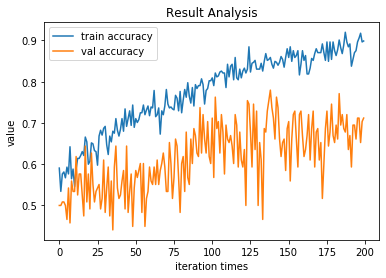

In [80]:
# -*- coding: UTF-8 -*-
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


#x_axix，train_pn_dis这些都是长度相同的list()
# print(his['train_loss'])
x_axix = range(len(his['train_loss']))
#开始画图
sub_axix = filter(lambda x:x%200 == 0, x_axix)
plt.title('Result Analysis')
plt.plot(x_axix, his['train_acc'],  label='train accuracy')
plt.plot(x_axix, his['val_acc'], label='val accuracy')

# plt.plot(x_axix,his['train_loss'],  color='skyblue', label='train loss')
# plt.plot(x_axix, his['val_loss'], color='blue', label='val loss')
plt.legend() # 显示图例

plt.xlabel('iteration times')
plt.ylabel('value')
plt.show()
#python 一个折线图绘制多个曲线

In [ ]:
import pandas as pd
df = pd.DataFrame(his)
df.to_csv('/data/cv_final/CT-Predict/2D-Pretrain/result/his.csv')

In [ ]:
pred_path = '/data/Data/prediction_img'
import glob
file_list = sorted(glob.glob(pred_path+"/*.npy"))
file_list 

In [ ]:
import numpy as np
target_list = file_list[10]
input = np.empty([1, 128, 128 ,3])
# for idx, p in enumerate(target_list):
for c in range(3):
    print(c)
    input[0, :, :, c] = np.resize(np.load(p, allow_pickle=True), (128, 128))

print(input.shape)

In [ ]:
model.eval()
# input = input.resize([128, 128])
print(input.shape)
i = torch.tensor(input, dtype=torch.float).to(device)
i = i.permute(3,0,1,2) # to (C,D,H,W)
i = i.reshape([1, 3, 128, 128]).to(device)
output = model(i)
output

In [ ]:
score = F.softmax(output, dim=1)
score.shape

In [ ]:
 output.argmax(dim=1, keepdim=True)